In [1]:
import os
import sys


def configure_python_path():
    project_root = os.path.abspath(
        os.path.join('..')
    )
    if project_root not in sys.path:
        sys.path.insert(0, project_root)

# Apply the path tweak before any project imports
configure_python_path()

Analize ratio de compresión de los resumenes LLM

/home/leon/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (11302 > 8192). Running this sequence through the model will result in indexing errors


Mean ratio: 0.1927
Mediana: 0.1744
Desviación estándar: 0.1112
Máximo: 0.9366
Mínimo: 0.0063


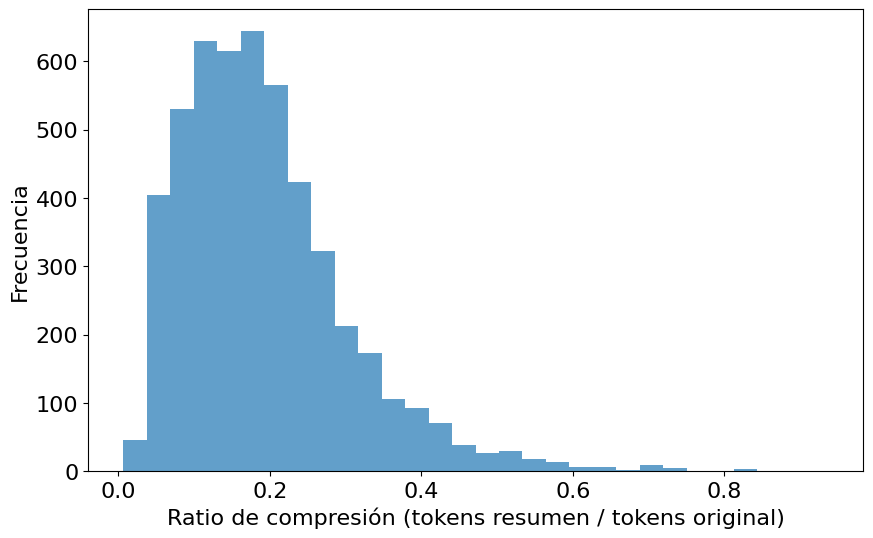

In [ ]:
from transformers import AutoTokenizer
import pandas as pd
from config.config import STORAGE_DIR
from src.utils.retrieval_utils import get_legal_dataset
import matplotlib.pyplot as plt

figsize = (10, 6)  # Width, Height in inches
dpi = 100  # Dots per inch for the figure
plt.rcParams['font.size'] = 16

# Choose a tokenizer (use the one your models use)
tokenizer = AutoTokenizer.from_pretrained("mrm8488/legal-longformer-base-8192-spanish")

base_dir = os.path.join(STORAGE_DIR, "legal_ir", "data")

# Load documents
dids, docs = get_legal_dataset(os.path.join(base_dir, "corpus", "corpus.jsonl"))
dids_summaries, docs_summaries = get_legal_dataset(os.path.join(base_dir, "corpus", "corpus_mistral_summaries_1024.jsonl"))

ratios = []
for orig, resum in zip(docs, docs_summaries):
    orig_len = len(tokenizer.tokenize(orig))
    resum_len = len(tokenizer.tokenize(resum))
    ratio = resum_len / orig_len if orig_len > 0 else 0
    ratios.append(ratio)

print(f"Mean ratio: {sum(ratios) / len(ratios):.4f}")
print(f"Mediana: {pd.Series(ratios).median():.4f}")
print(f"Desviación estándar: {pd.Series(ratios).std():.4f}")
print(f"Máximo: {max(ratios):.4f}")
print(f"Mínimo: {min(ratios):.4f}")


plt.figure(figsize=figsize, dpi=dpi)
plt.hist(ratios, bins=30, alpha=0.7)
plt.xlabel("Ratio de compresión (tokens resumen / tokens original)")
plt.ylabel("Frecuencia")
# plt.title("Distribución del ratio de compresión de resúmenes legales")
plt.show()


Exactitud de artículos

In [14]:
import re

def extraer_articulos_old(texto):
    # Busca coincidencias como "Artículo 123", "Art. 123", etc.
    # Devuelve solo el número como string
    pattern = r"Art(?:[íi]culo)?\.?\s*(\d+)"
    return re.findall(pattern, texto, flags=re.IGNORECASE)

def extraer_articulos(texto):
    # Busca coincidencias como "Artículo 123", "Art. 123", etc.
    # Devuelve solo el número como string
    pattern = r"\d+"
    return re.findall(pattern, texto, flags=re.IGNORECASE)

In [17]:
def extraer_citas_relevantes(resumen):
    """
    Extrae el texto bajo el encabezado 'Citas relevantes' en un resumen.
    Devuelve una cadena (puede estar vacía si no existe la sección).
    """
    # Busca el encabezado y todo lo que le sigue (hasta el final o un próximo encabezado, por si acaso)
    match = re.search(r"Citas relevantes\s*[:-]?\s*(.+)", resumen, flags=re.IGNORECASE | re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        print("No se encontró la sección 'Citas relevantes' en el resumen.")
        return ""  # No se encontró la sección


In [18]:
results = []
for resumen, original in zip(docs_summaries, docs):
    citas = extraer_citas_relevantes(resumen)
    arts_resumen = set(extraer_articulos(citas))
    arts_original = set(extraer_articulos(original))
    # Precisión: de los citados en el resumen, ¿cuántos aparecen en el doc original?
    if arts_resumen:
        exactitud = len(arts_resumen & arts_original) / len(arts_resumen)
    else:
        exactitud = None  # O 0, pero así puedes filtrar luego
    results.append({
        "n_citas_resumen": len(arts_resumen),
        "n_citas_en_doc": len(arts_resumen & arts_original),
        "exactitud": exactitud
    })

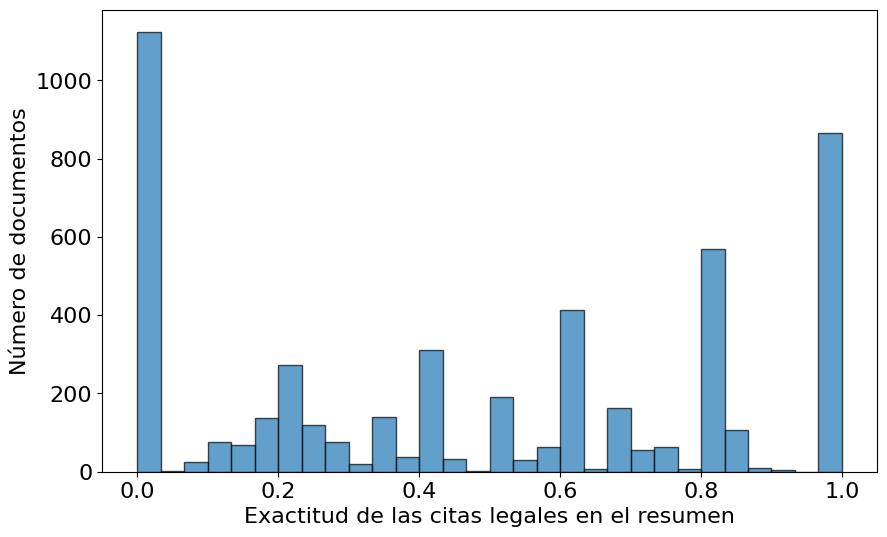

count    4994.000000
mean        0.477589
std         0.363465
min         0.000000
25%         0.142857
50%         0.500000
75%         0.800000
max         1.000000
Name: exactitud, dtype: float64


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df = df.dropna(subset=['exactitud'])  # Quita los casos donde no hubo citas en el resumen

plt.figure(figsize=figsize, dpi=dpi)
plt.hist(df['exactitud'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Exactitud de las citas legales en el resumen")
plt.ylabel("Número de documentos")
# plt.title("Distribución de la exactitud de las citas relevantes extraídas por el LLM")
plt.show()

# También puedes mostrar la media, mediana, etc.
print(df['exactitud'].describe())


### Análisis de preprocesamiento por LLM

In [8]:
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
import pandas as pd
from config.config import STORAGE_DIR
from src.utils.retrieval_utils import get_legal_dataset
import matplotlib.pyplot as plt

figsize = (10, 6)  # Width, Height in inches
dpi = 100  # Dots per inch for the figure
plt.rcParams['font.size'] = 16

# Choose a tokenizer (use the one your models use)
tokenizer = AutoTokenizer.from_pretrained("mrm8488/legal-longformer-base-8192-spanish")

base_dir = os.path.join(STORAGE_DIR, "legal_ir", "data")

# Load documents
_, docs = get_legal_dataset(os.path.join(base_dir, "corpus", "corpus_raw_google_ocr.jsonl"))
_, docs_llm = get_legal_dataset(os.path.join(base_dir, "corpus", "corpus_Gpt4o-mini_cleaned.jsonl"))

# docs_originales, docs_llm (misma longitud y orden)
orig_lengths = [len(tokenizer.tokenize(d)) for d in docs]
llm_lengths = [len(tokenizer.tokenize(d)) for d in docs_llm]

# Calcula métricas
diff_abs = [llm - orig for llm, orig in zip(llm_lengths, orig_lengths)]
ratio = [llm / orig if orig > 0 else 0 for llm, orig in zip(llm_lengths, orig_lengths)]
reduction = [1 - r for r in ratio]


Token indices sequence length is longer than the specified maximum sequence length for this model (12656 > 8192). Running this sequence through the model will result in indexing errors


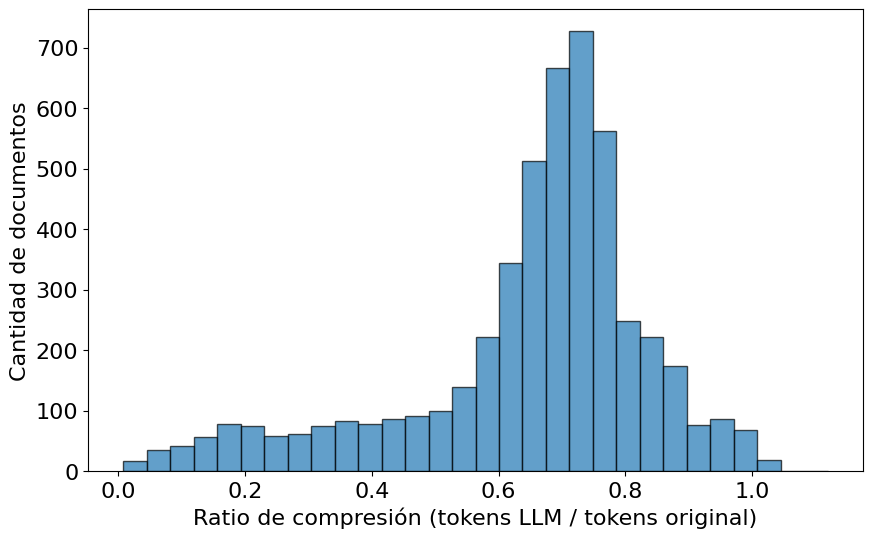

Reducción media: 0.6497954400722953
Reducción mediana: 0.6957386099668597
Reducción mínima: 0.007528246027430367
Reducción máxima: 1.1198738170347002


In [9]:
# Visualiza histograma del ratio (reducción)
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(ratio, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Ratio de compresión (tokens LLM / tokens original)')
plt.ylabel('Cantidad de documentos')
# plt.title('Distribución del porcentaje de reducción de longitud')
plt.show()

# Tabla resumen
import numpy as np
print("Reducción media:", np.mean(ratio))
print("Reducción mediana:", np.median(ratio))
print("Reducción mínima:", np.min(ratio))
print("Reducción máxima:", np.max(ratio))

In [ ]:
from transformers import AutoTokenizer
import pandas as pd
from config.config import STORAGE_DIR
from src.utils.retrieval_utils import get_legal_dataset, get_legal_queries

# Choose a tokenizer (use the one your models use)
tokenizer = AutoTokenizer.from_pretrained("mrm8488/legal-longformer-base-8192-spanish")

base_dir = os.path.join(STORAGE_DIR, "legal_ir", "data")

# Load queries
qids, queries = get_legal_queries(os.path.join(base_dir, "corpus", "queries_54.tsv"))

# Load documents
dids, docs = get_legal_dataset(os.path.join(base_dir, "corpus", "corpus_mistral_summaries_1024.jsonl"))

# Tokenize queries and count token lengths
query_token_lengths = [len(tokenizer.tokenize(q)) for q in queries]

# # Tokenize documents and count token lengths
doc_token_lengths = [len(tokenizer.tokenize(d)) for d in docs]

avg_doc_length = sum(doc_token_lengths) / len(doc_token_lengths)
print("Average document token length:", avg_doc_length)
print("Max document token length:", max(doc_token_lengths))
print("Min document token length:", min(doc_token_lengths))

/home/leon/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Average document token length: 524.131026205241
Max document token length: 819
Min document token length: 329


/tmp/ipykernel_1971995/2358710854.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


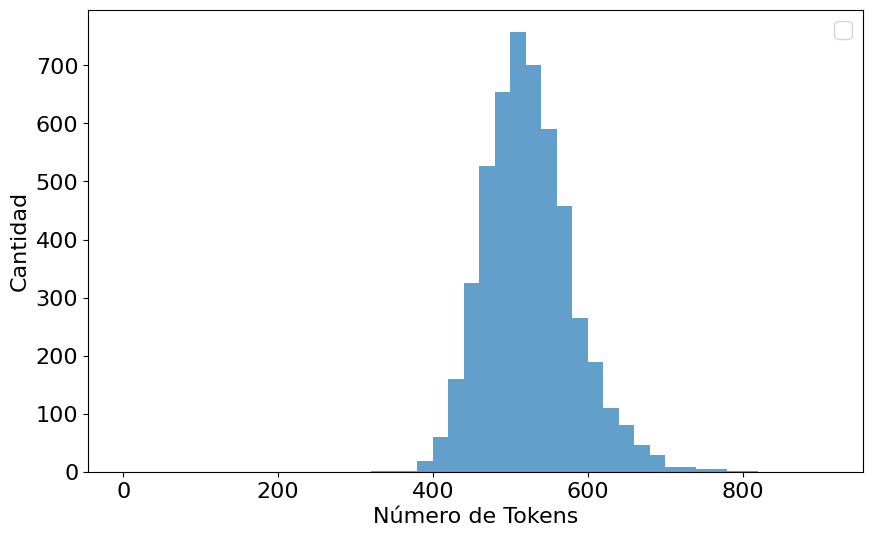

In [20]:
import numpy as np
import matplotlib.pyplot as plt

threshold = 900
bin_width = 20
figsize = (10, 6)  # Width, Height in inches
dpi = 100  # Dots per inch for the figure
plt.rcParams['font.size'] = 16

# Separate below-threshold and count above-threshold
below = [x for x in doc_token_lengths if x < threshold]
above_count = len(doc_token_lengths) - len(below)

# Prepare bins and counts
bins = np.arange(0, threshold + bin_width, bin_width)
counts, edges = np.histogram(below, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

# Create figure with desired size and resolution
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot bars
ax.bar(centers, counts, width=bin_width, align='center', alpha=0.7)
ax.bar(threshold, above_count, width=bin_width, align='center', alpha=0.7)

# Labels and legend
ax.set_xlabel('Número de Tokens')
ax.set_ylabel('Cantidad')
ax.legend()

Distribucion de longitud de chunking por párrafos

In [3]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from config.config import STORAGE_DIR
from src.utils.retrieval_utils import get_legal_dataset

# ---------- 1) Cargar documentos originales ----------
base_dir = os.path.join(STORAGE_DIR, "legal_ir", "data")
dids, docs = get_legal_dataset(os.path.join(base_dir, "corpus", "corpus_Gpt4o-mini_cleaned.jsonl"))
doc_dict = dict(zip(dids, docs))

# ---------- 2) Instanciar el mismo tokenizer que usas en tu modelo ----------
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3", use_fast=True)

# ---------- 3) Dividir en párrafos y medir longitud en tokens ----------
paragraph_token_lengths = []
for text in tqdm(doc_dict.values(), desc="Procesando párrafos"):
    paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
    for para in paragraphs:
        tok_len = len(tokenizer.tokenize(para))
        paragraph_token_lengths.append(tok_len)

print(f"Total de párrafos analizados: {len(paragraph_token_lengths):,}")


Procesando párrafos: 100%|██████████| 5000/5000 [00:29<00:00, 169.85it/s]

Total de párrafos analizados: 135,286


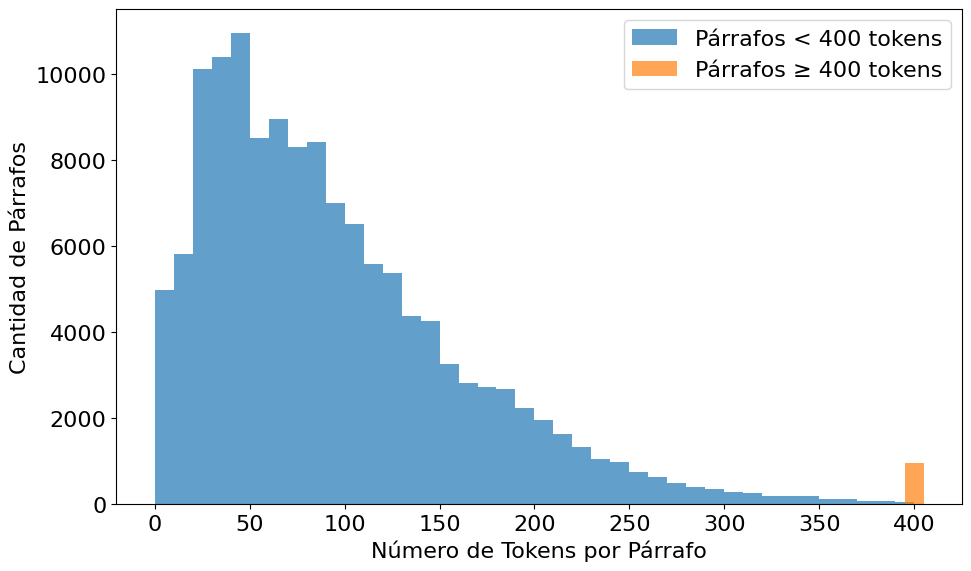

In [5]:
# ---------- 4) Configuración del histograma (idéntica a tu script) ----------
threshold = 400     # Máx. mostrado en barras individuales
bin_width  = 10
figsize    = (10, 6)
dpi        = 100
plt.rcParams['font.size'] = 16

# Separar y contar
below       = [x for x in paragraph_token_lengths if x < threshold]
above_count = len(paragraph_token_lengths) - len(below)

# Bins y conteos
bins    = np.arange(0, threshold + bin_width, bin_width)
counts, edges = np.histogram(below, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

# ---------- 5) Dibujar ----------
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

ax.bar(centers, counts, width=bin_width, align='center', alpha=0.7,
       label=f'Párrafos < {threshold} tokens')
ax.bar(threshold, above_count, width=bin_width, align='center', alpha=0.7,
       label=f'Párrafos ≥ {threshold} tokens')

# Etiquetas
ax.set_xlabel('Número de Tokens por Párrafo')
ax.set_ylabel('Cantidad de Párrafos')
# ax.set_title('Distribución de longitudes de párrafos tras el preprocesamiento')
ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_1971995/2495126517.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


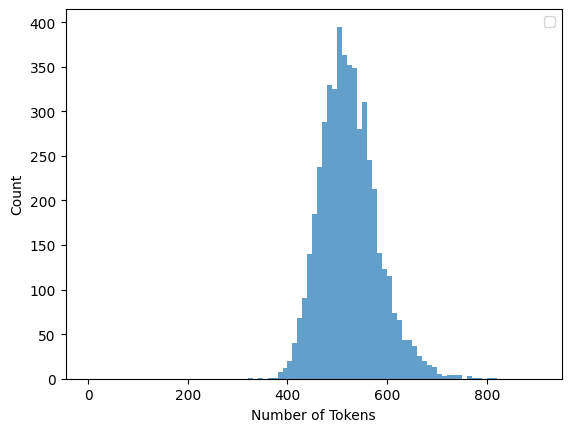

/tmp/ipykernel_1971995/2495126517.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Queries below threshold: 54
Queries above threshold: 0


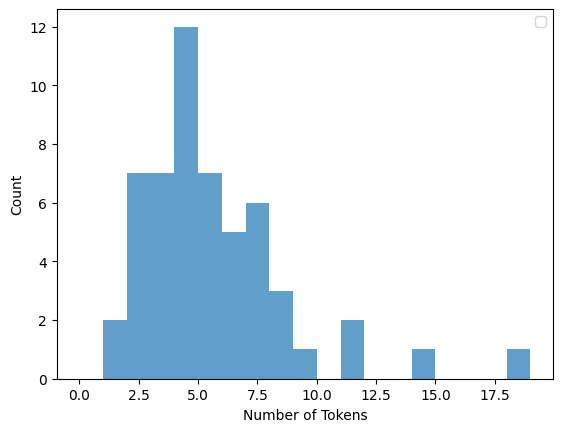

Query Token Length Stats:
Mean: 5.17
Median: 4.00
Max: 18
Min: 1


In [8]:
import numpy as np
import matplotlib.pyplot as plt

threshold = 900
q_threshold = 20

# Count docs below and above threshold
below_threshold = [x for x in doc_token_lengths if x < threshold]
above_threshold_count = len(doc_token_lengths) - len(below_threshold)

# Create histogram for docs below threshold
bins = np.arange(0, threshold, 10)
counts, bin_edges = np.histogram(below_threshold, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot histogram for docs below threshold
# plt.bar(bin_centers, counts, width=10, align='center', alpha=0.7, label="Docs < 20k tokens")
plt.bar(bin_centers, counts, width=10, align='center', alpha=0.7)
# Add one bar for docs >=20k tokens at position threshold
# plt.bar(threshold, above_threshold_count, width=10, align='center', alpha=0.7, label="Docs >= 20k tokens")
plt.bar(threshold, above_threshold_count, width=10, align='center', alpha=0.7)
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
# plt.title("Document Token Length Distribution (with 20k+ grouped)")
plt.legend()
plt.show()

# Count queries below and above threshold
below_q_threshold = [x for x in query_token_lengths if x < q_threshold]
above_q_threshold_count = len(query_token_lengths) - len(below_q_threshold)
print("Queries below threshold:", len(below_q_threshold))
print("Queries above threshold:", above_q_threshold_count)

# Create histogram for queries below threshold
bins = np.arange(0, q_threshold, 1)
counts, bin_edges = np.histogram(below_q_threshold, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot histogram for queries below threshold
plt.bar(bin_centers, counts, width=1, align='center', alpha=0.7)
# Add one bar for queries >=20 tokens at position threshold
# plt.bar(q_threshold, above_q_threshold_count, width=1, align='center', alpha=0.7, label="Queries >= 20 tokens")
plt.xlabel("Number of Tokens")
plt.ylabel("Count")
# plt.title("Query Token Length Distribution (with 20+ grouped)")
# plt.title("Query Token Length Distribution")
plt.legend()
plt.show()

# Compute statistics
print("Query Token Length Stats:")
print(f"Mean: {np.mean(query_token_lengths):.2f}")
print(f"Median: {np.median(query_token_lengths):.2f}")
print(f"Max: {np.max(query_token_lengths)}")
print(f"Min: {np.min(query_token_lengths)}")

# print("\nDocument Token Length Stats:")
# print(f"Mean: {np.mean(doc_token_lengths):.2f}")
# print(f"Median: {np.median(doc_token_lengths):.2f}")
# print(f"Max: {np.max(doc_token_lengths)}")
# print(f"Min: {np.min(doc_token_lengths)}")

AttributeError: module 'matplotlib.pyplot' has no attribute 'xaxis'

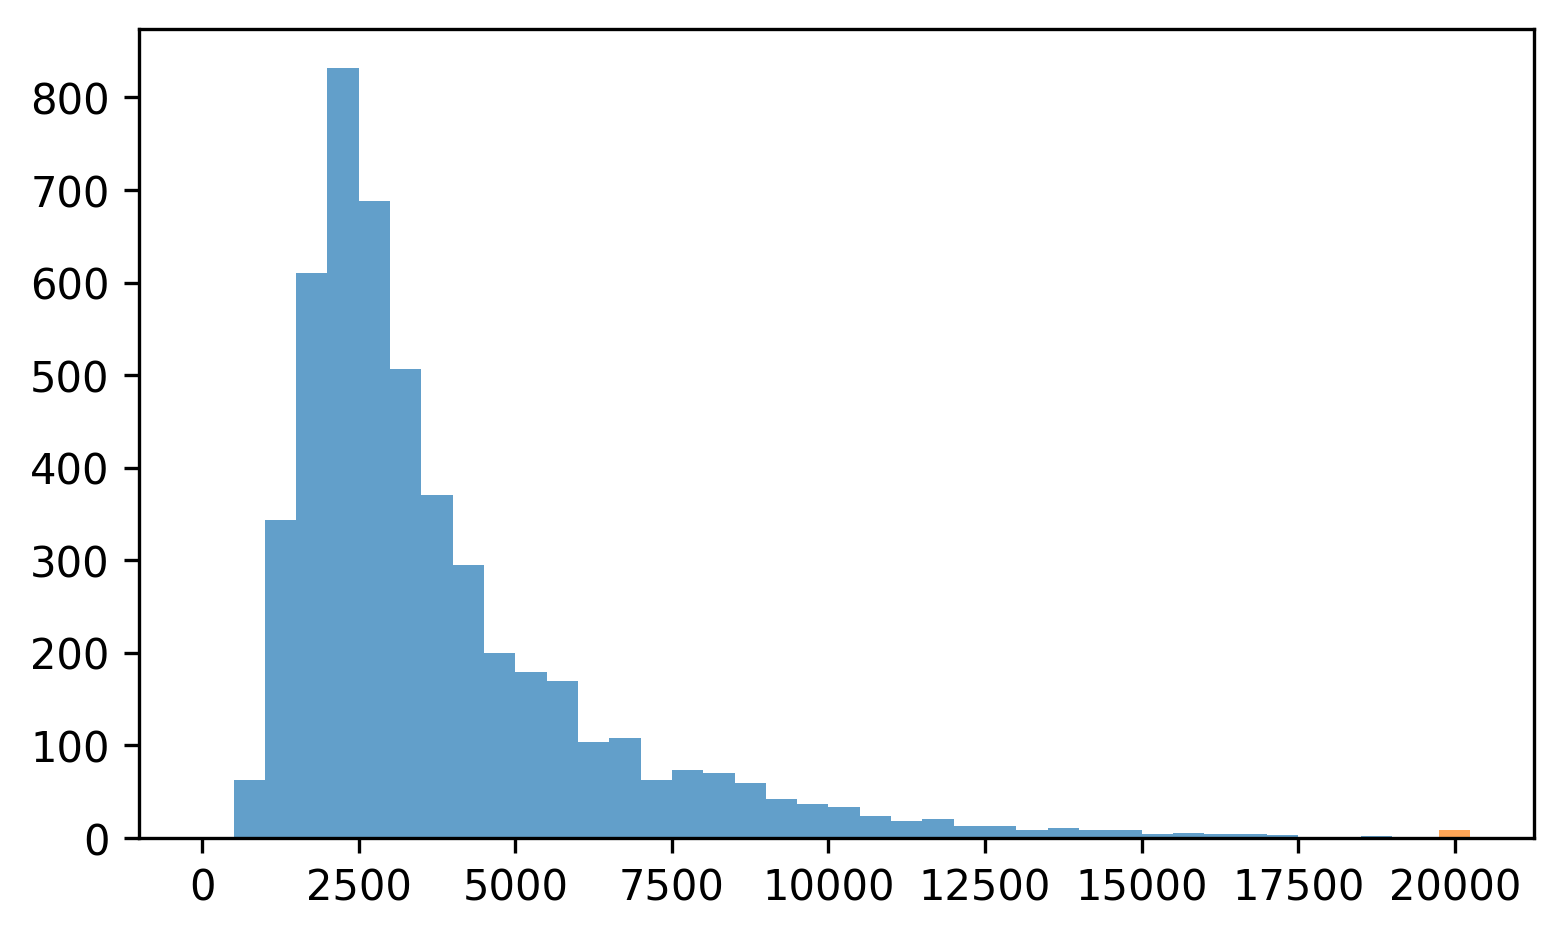

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f'{int(x/1000)}k'

# thresholds
doc_threshold = 20_000
q_threshold   = 20

# --- Document histogram ---
# Count docs below/above threshold
below = [x for x in doc_token_lengths if x < doc_threshold]
above_count = len(doc_token_lengths) - len(below)

# bins every 500 tokens up to threshold
bins = np.arange(0, doc_threshold + 500, 500)
counts, edges = np.histogram(below, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2

plt.figure(figsize=(6, 3.5), dpi=300)
plt.bar(centers, counts, width=500, align='center', alpha=0.7, label='Docs < 20 k tokens')
# one extra bar for ≥20 k
plt.bar(doc_threshold, above_count, width=500, align='center', alpha=0.7, label='Docs ≥ 20 k tokens')
plt.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

plt.xlabel("Number of Tokens", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, frameon=False)
plt.tight_layout()
plt.show()

# --- Query histogram ---
below_q = [x for x in query_token_lengths if x < q_threshold]
above_q = len(query_token_lengths) - len(below_q)

bins_q = np.arange(0, q_threshold + 1, 1)
counts_q, edges_q = np.histogram(below_q, bins=bins_q)
centers_q = (edges_q[:-1] + edges_q[1:]) / 2

plt.figure(figsize=(6, 3.5), dpi=300)
plt.bar(centers_q, counts_q, width=1, align='center', alpha=0.7)
# optionally add bar for ≥ threshold:
plt.bar(q_threshold, above_q, width=1, align='center', alpha=0.7)

plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# no legend needed for this one
plt.tight_layout()
plt.show()

# --- Query stats ---
print("Query Token Length Stats:")
print(f" Mean:   {np.mean(query_token_lengths):.2f}")
print(f" Median: {np.median(query_token_lengths):.2f}")
print(f" Min:    {np.min(query_token_lengths)}")
print(f" Max:    {np.max(query_token_lengths)}")


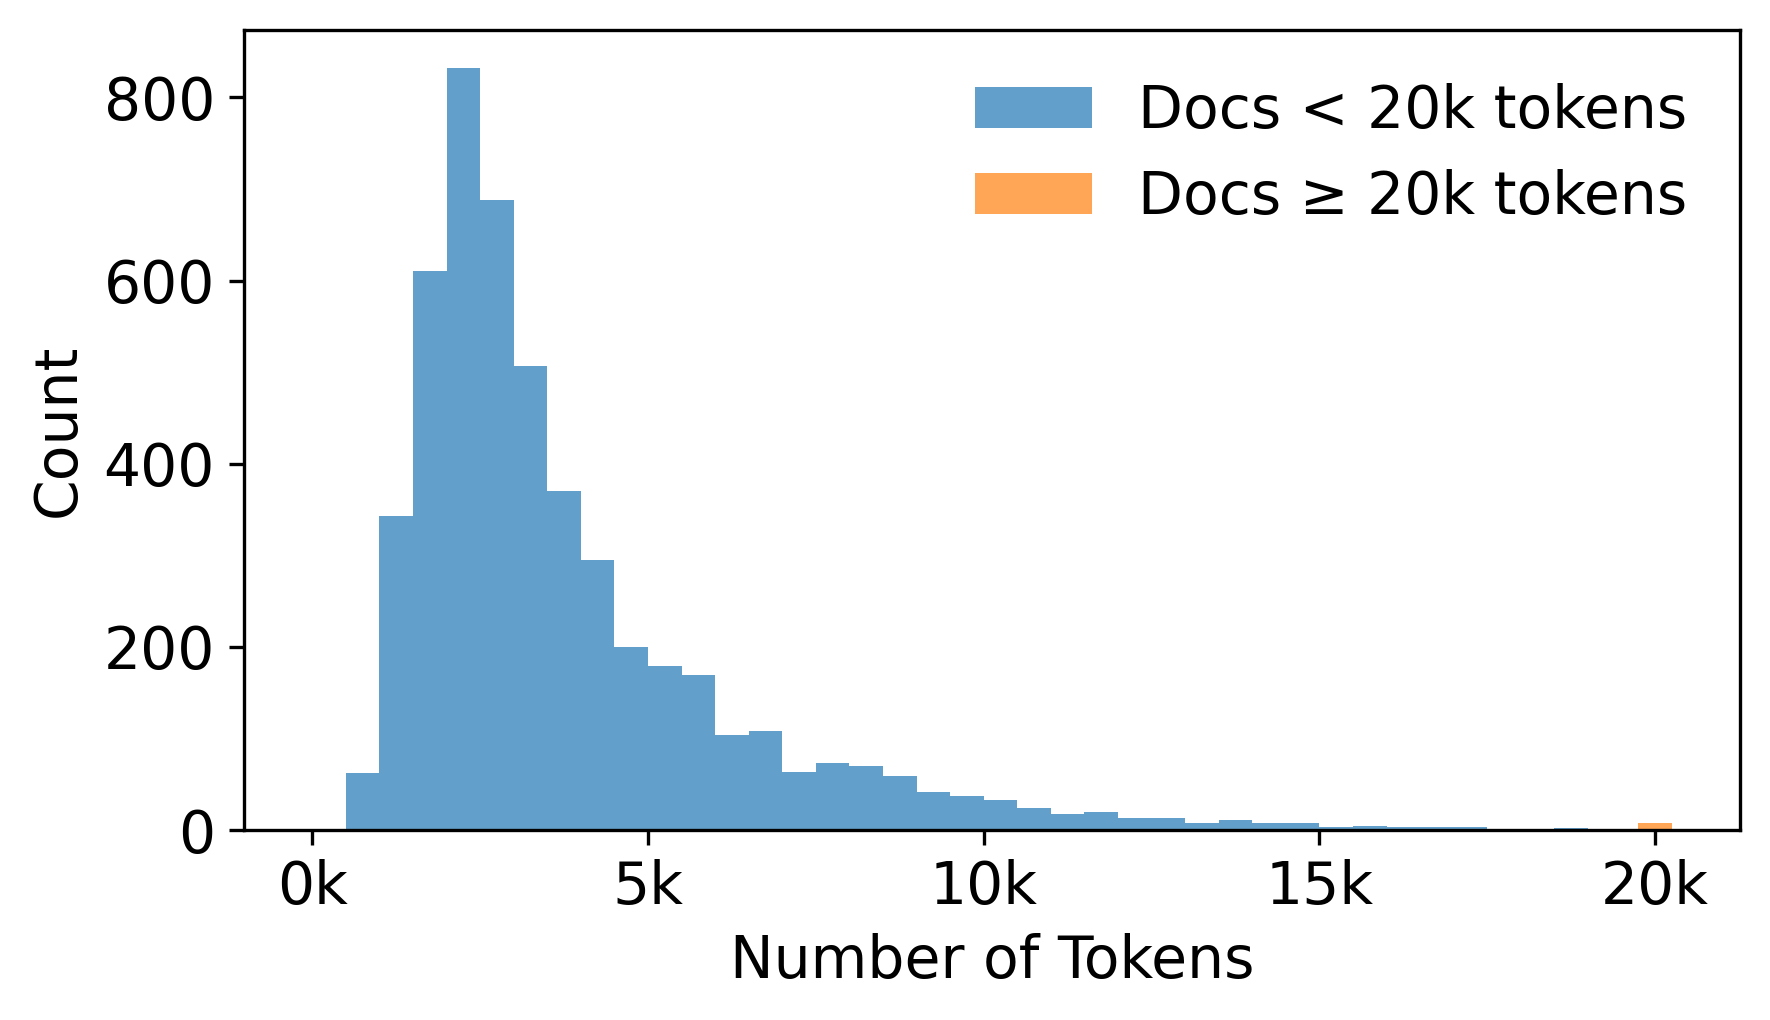

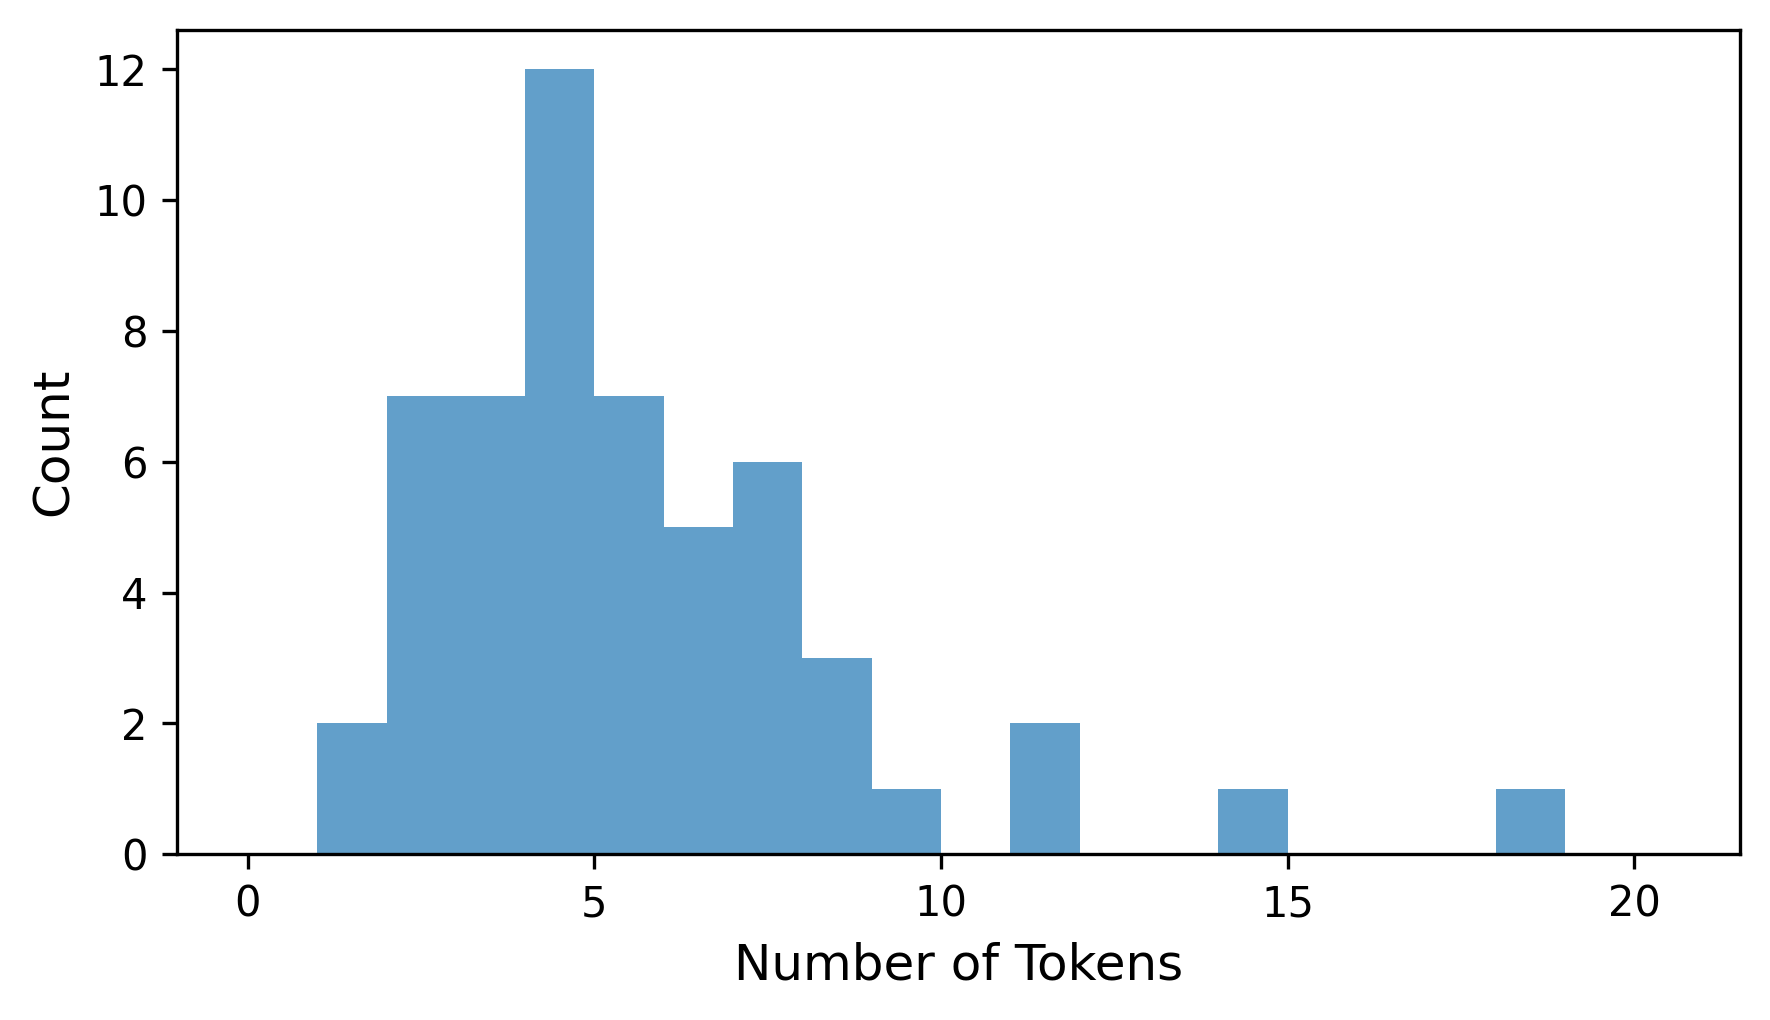

Query Token Length Stats:
 Mean:   5.17
 Median: 4.00
 Min:    1
 Max:    18


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def thousands_formatter(x, pos):
    """Format tick label as thousands with 'k' suffix.

    Parameters
    ----------
    x : float
        Tick value.
    pos : int
        Tick position (unused).

    Returns
    -------
    str
        Formatted tick label (e.g., '20k').
    """
    return f"{int(x / 1000)}k"


def plot_histograms(doc_token_lengths, query_token_lengths):
    """Plot document and query token histograms with formatted axes.

    Document histogram uses a threshold at 20_000 tokens and formats
    x-axis labels in 'k'. Query histogram uses a threshold at 20 tokens.

    Parameters
    ----------
    doc_token_lengths : list of int
        Token counts for documents.
    query_token_lengths : list of int
        Token counts for queries.

    Returns
    -------
    None
    """
    # Thresholds
    doc_threshold = 20_000
    q_threshold = 20

    # --- Document histogram ---
    below = [x for x in doc_token_lengths if x < doc_threshold]
    above_count = len(doc_token_lengths) - len(below)

    bins = np.arange(0, doc_threshold + 500, 500)
    counts, edges = np.histogram(below, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    fig, ax = plt.subplots(figsize=(6, 3.5), dpi=300)
    ax.bar(centers, counts, width=500, align="center", alpha=0.7,
           label="Docs < 20k tokens")
    ax.bar(doc_threshold, above_count, width=500, align="center",
           alpha=0.7, label="Docs ≥ 20k tokens")
    ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    ax.set_xlabel("Number of Tokens", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.legend(fontsize=14, frameon=False)
    fig.tight_layout()
    plt.show()

    # --- Query histogram ---
    below_q = [x for x in query_token_lengths if x < q_threshold]
    above_q = len(query_token_lengths) - len(below_q)

    bins_q = np.arange(0, q_threshold + 1, 1)
    counts_q, edges_q = np.histogram(below_q, bins=bins_q)
    centers_q = (edges_q[:-1] + edges_q[1:]) / 2

    fig, ax = plt.subplots(figsize=(6, 3.5), dpi=300)
    ax.bar(centers_q, counts_q, width=1, align="center", alpha=0.7)
    ax.bar(q_threshold, above_q, width=1, align="center", alpha=0.7)

    ax.set_xlabel("Number of Tokens", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    fig.tight_layout()
    plt.show()

    # --- Query stats ---
    print("Query Token Length Stats:")
    print(f" Mean:   {np.mean(query_token_lengths):.2f}")
    print(f" Median: {np.median(query_token_lengths):.2f}")
    print(f" Min:    {np.min(query_token_lengths)}")
    print(f" Max:    {np.max(query_token_lengths)}")


# Example usage:
plot_histograms(doc_token_lengths, query_token_lengths)


label
0    8888
1    3396
Name: count, dtype: int64


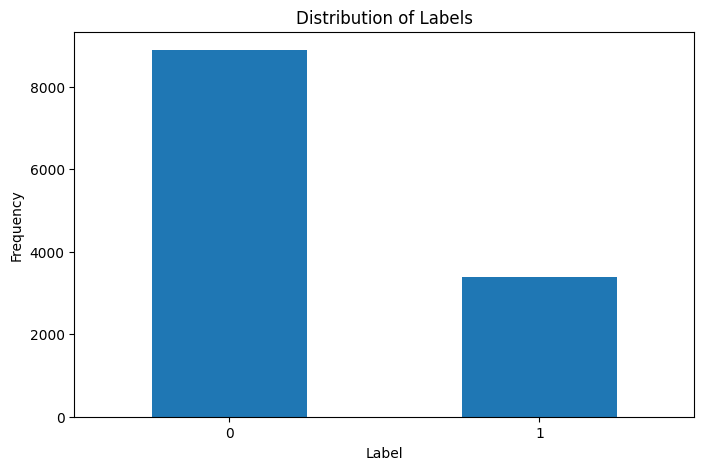

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("home/leon/tesis/messirve-ir")
from config.config import STORAGE_DIR

# Load the TSV file into a DataFrame
# Adjust the file path as needed.
df = pd.read_csv(
    os.path.join(STORAGE_DIR, "legal_ir", "data", "annotations", "qrels_synthetic_mistral-small-2501.tsv"),
    sep="\t",
    header=None,
    names=["qid", "run", "doc_id", "label"]
)

# Count the frequency of each label
label_counts = df["label"].value_counts().sort_index()
print(label_counts)

# Plot the label distribution as a bar chart
plt.figure(figsize=(8, 5))
label_counts.plot(kind="bar")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels")
plt.xticks(rotation=0)
plt.show()


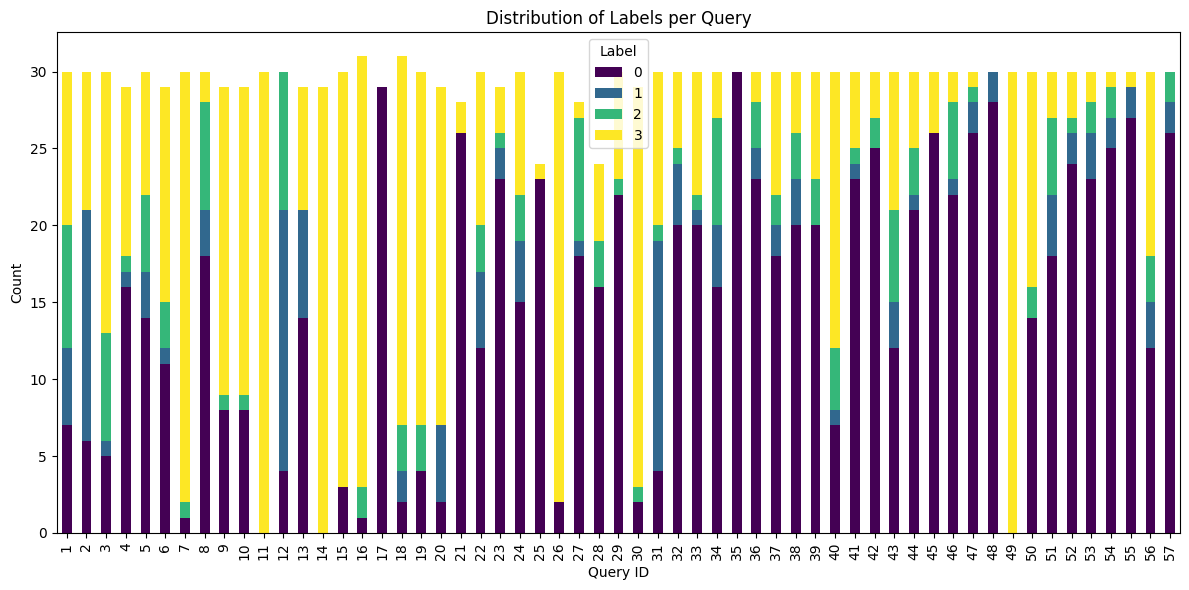

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# # Load the TSV file into a DataFrame
df = pd.read_csv("/media/discoexterno/leon/legal_ir/data/annotations/qrels_py.tsv", sep="\t", header=None, names=["qid", "run", "doc_id", "label"])

# Group by query and label, then count frequencies
grouped = df.groupby(["qid", "label"]).size().reset_index(name="count")

# Pivot the data so that each row is a query and columns are the labels
pivot_df = grouped.pivot(index="qid", columns="label", values="count").fillna(0)

# Plot a stacked bar chart for each query
pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Query ID")
plt.ylabel("Count")
plt.title("Distribution of Labels per Query")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

# # after pivot_df = …
# threshold = 7

# # compute how many positives (label 2 or 3) each query has
# pos_counts = pivot_df.get(2, 0) + pivot_df.get(3, 0)

# # compute how many POS labels each query is missing
# missing_counts = (threshold - pos_counts).clip(lower=0)

# # keep only those that are actually missing something
# missing_counts = missing_counts[missing_counts > 0]

# # display
# for qid, miss in missing_counts.items():
#     print(f"Query {qid}: missing {miss:.0f} positive annotations")



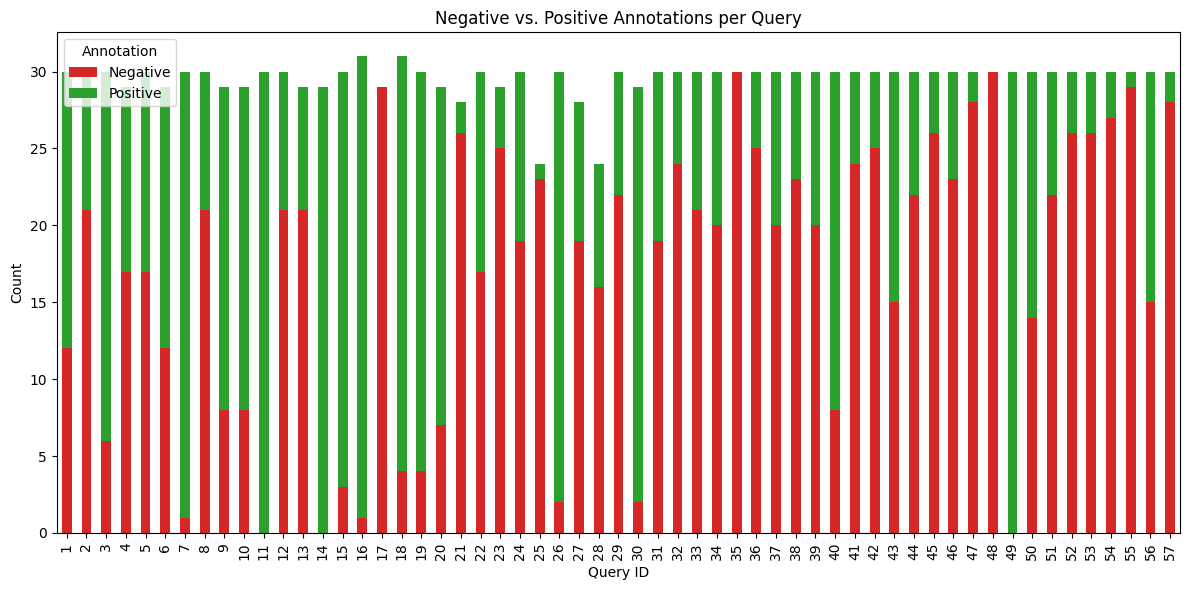

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the TSV file into a DataFrame
df = pd.read_csv("qrels_py.tsv", sep="\t", header=None,
                 names=["qid", "run", "doc_id", "label"])

# Pivot original counts so we have columns for labels 0,1,2,3
grouped = df.groupby(["qid", "label"]).size().unstack(fill_value=0)

# Compute “Negative” = labels 0+1 and “Positive” = labels 2+3
grouped["Negative"] = grouped.get(0, 0) + grouped.get(1, 0)
grouped["Positive"] = grouped.get(2, 0) + grouped.get(3, 0)

# Keep only the binary columns and plot
binary_df = grouped[["Negative", "Positive"]]

binary_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=["#d62728", "#2ca02c"],  # optional: red for negative, green for positive
)

plt.xlabel("Query ID")
plt.ylabel("Count")
plt.title("Negative vs. Positive Annotations per Query")
plt.legend(title="Annotation")
plt.tight_layout()
plt.show()


Distribution of Labels of the medium- and easy-negatives enhanced binary dataset (For training BCE cross-encoder)

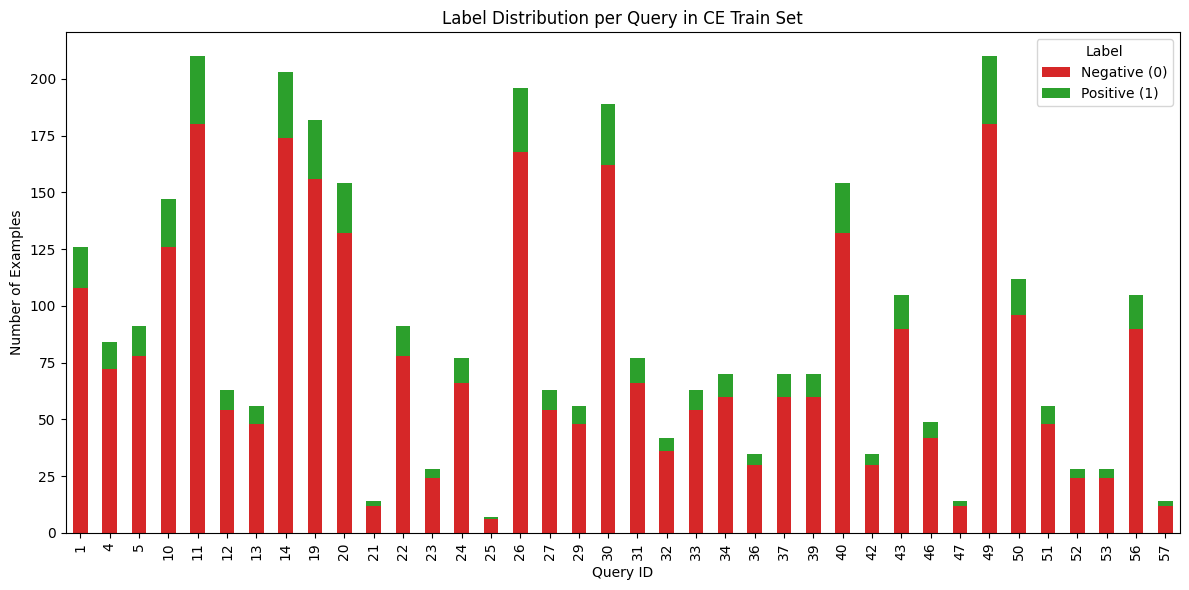

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.expanduser("~/tesis/messirve-ir"))
from config.config import STORAGE_DIR

# Path to the CE train dataset
train_path = os.path.join(
    STORAGE_DIR, "legal_ir", "data",
    "datasets", "cross_encoder", "bce_train.tsv"
)

# Load only the query IDs and labels
df = pd.read_csv(train_path, sep="\t", usecols=["qid", "label"])

# Count negatives (0) vs positives (1) per query
counts = (
    df.groupby(["qid", "label"])
      .size()
      .unstack(fill_value=0)
)
counts.columns = ["Negative (0)", "Positive (1)"]

# Plot the stacked bar chart
counts.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=["#d62728", "#2ca02c"]
)
plt.xlabel("Query ID")
plt.ylabel("Number of Examples")
plt.title("Label Distribution per Query in CE Train Set")
plt.legend(title="Label")
plt.tight_layout()
plt.show()


In [10]:
import os
import pandas as pd
from config.config import STORAGE_DIR

# Path to the CE train dataset
train_path = os.path.join(
    STORAGE_DIR, "legal_ir", "data",
    "datasets", "cross-encoder", "bce_train.tsv"
)

# Load query IDs and labels
df = pd.read_csv(train_path, sep="\t", usecols=["qid", "label"])

# Count negatives (0) vs positives (1) per query
counts = df.groupby(["qid", "label"]).size().unstack(fill_value=0)
counts.columns = ["neg", "pos"]

# Total number of annotations
total_annotations = counts["neg"].sum() + counts["pos"].sum()
print(f"Total annotations: {total_annotations}")

# Compute positive/negative ratio per query
counts["pos_neg_ratio"] = counts["neg"] / counts["pos"].replace(0, pd.NA)

# Print per-query stats
for qid, row in counts.iterrows():
    print(f"Query {qid}: pos={row['pos']}, neg={row['neg']}, ratio={row['pos_neg_ratio']:.2f}")


Total annotations: 2730
Query 1: pos=18.0, neg=108.0, ratio=6.00
Query 4: pos=12.0, neg=72.0, ratio=6.00
Query 5: pos=13.0, neg=43.0, ratio=3.31
Query 10: pos=21.0, neg=126.0, ratio=6.00
Query 11: pos=30.0, neg=180.0, ratio=6.00
Query 12: pos=9.0, neg=54.0, ratio=6.00
Query 13: pos=8.0, neg=48.0, ratio=6.00
Query 14: pos=29.0, neg=174.0, ratio=6.00
Query 19: pos=26.0, neg=54.0, ratio=2.08
Query 20: pos=22.0, neg=51.0, ratio=2.32
Query 21: pos=2.0, neg=12.0, ratio=6.00
Query 22: pos=13.0, neg=43.0, ratio=3.31
Query 23: pos=4.0, neg=24.0, ratio=6.00
Query 24: pos=11.0, neg=41.0, ratio=3.73
Query 25: pos=1.0, neg=6.0, ratio=6.00
Query 26: pos=28.0, neg=168.0, ratio=6.00
Query 27: pos=9.0, neg=37.0, ratio=4.11
Query 29: pos=8.0, neg=48.0, ratio=6.00
Query 30: pos=27.0, neg=52.0, ratio=1.93
Query 31: pos=11.0, neg=66.0, ratio=6.00
Query 32: pos=6.0, neg=36.0, ratio=6.00
Query 33: pos=9.0, neg=39.0, ratio=4.33
Query 34: pos=10.0, neg=40.0, ratio=4.00
Query 36: pos=5.0, neg=30.0, ratio=6.00
Q

How many cases of type hurto were processed in between 2019 and 2023?

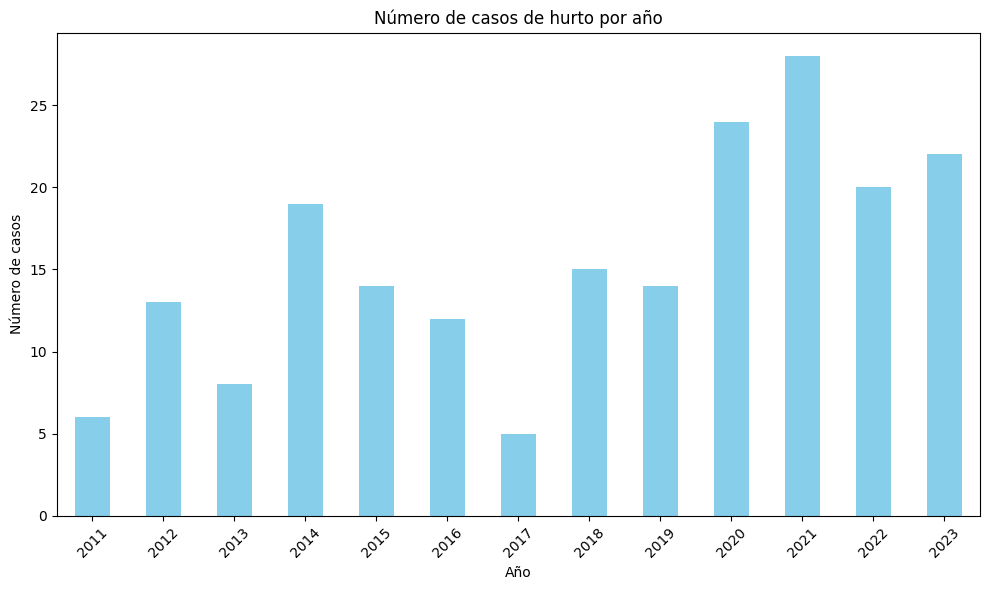

In [4]:
from config.config import STORAGE_DIR
import os
import pandas as pd
import matplotlib.pyplot as plt


corpus_dir = os.path.join(STORAGE_DIR, "legal_ir", "data", "corpus")
corpus_file = os.path.join(corpus_dir, "corpus_py.csv")

df = pd.read_csv(corpus_file, sep=",", usecols=["Codigo", "Año Resolución Judicial", "text"])

# cuántos casos de hurto (df[text] contains word 'hurto') hay por año
hurto_counts = df[df["text"].str.contains("hurto", case=False, na=False)] \
    .groupby("Año Resolución Judicial").size()

# Plot the counts
plt.figure(figsize=(10, 6))
hurto_counts.plot(kind='bar', color='skyblue')
plt.title("Número de casos de hurto por año")
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Tesseract vs Google OCR

✔ Saved figure to: /home/leon/tesis/messirve-ir/notebooks/ocr_comparison.png


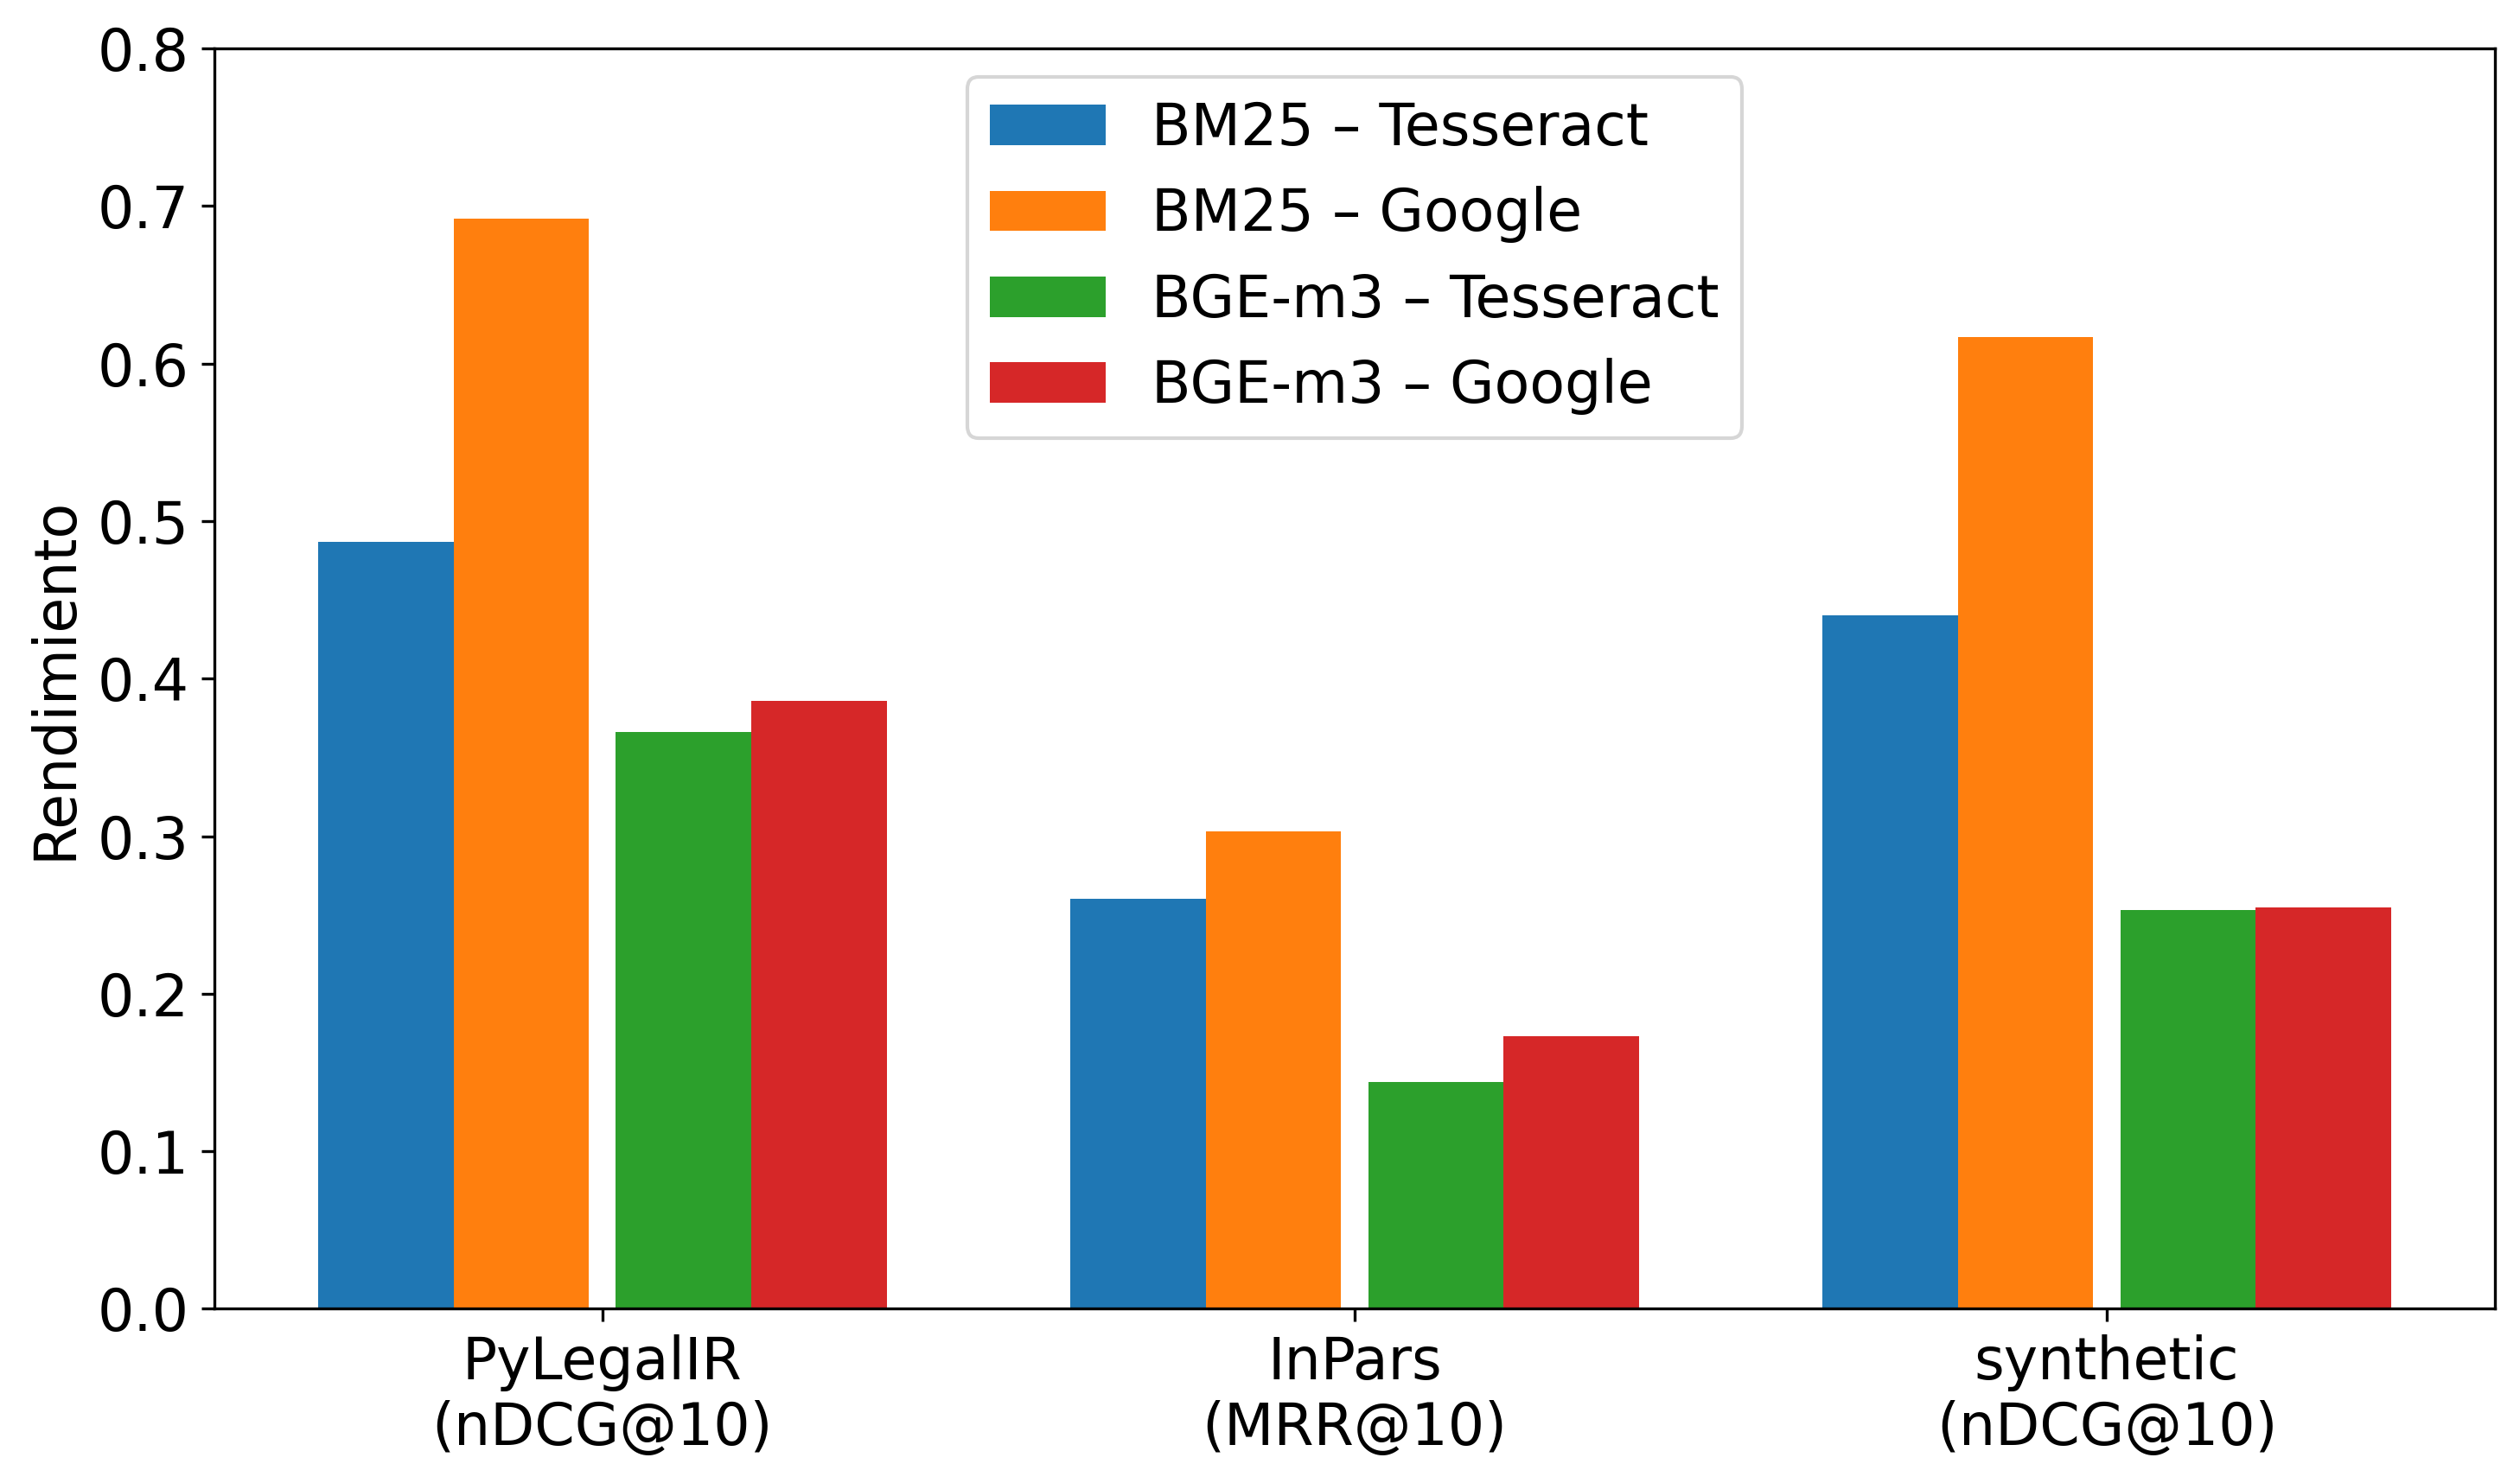

In [18]:
"""
Grouped-bar plot comparing Tesseract vs. Google OCR on three retrieval
benchmarks for two retrieval models (BM25 and BGE-m3).

The script shows the figure interactively and also saves it as
`ocr_comparison.png` in the working directory.
"""

from __future__ import annotations

import pathlib
from typing import Final

import matplotlib.pyplot as plt
import numpy as np


def plot_ocr_comparison() -> plt.Figure:
    """
    Create and return the OCR-comparison bar chart.

    Returns
    -------
    matplotlib.figure.Figure
        Handle to the generated figure.
    """
    # -----------------------------------------------------------------
    #  Data
    # -----------------------------------------------------------------
    datasets: Final[list[str]] = [
        "PyLegalIR\n(nDCG@10)",
        "InPars\n(MRR@10)",
        "synthetic\n(nDCG@10)",
    ]

    bm25_tess = np.array([0.487, 0.260, 0.440])
    bm25_goog = np.array([0.692, 0.303, 0.617])

    bge_tess = np.array([0.366, 0.144, 0.253])
    bge_goog = np.array([0.386, 0.173, 0.255])

    # -----------------------------------------------------------------
    #  Plot
    # -----------------------------------------------------------------
    x = np.arange(len(datasets))        # [0, 1, 2]
    bar_w = 0.18                        # width of each individual bar

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)  # one single plot (no sub-plots)

    # BM25 bars
    ax.bar(x - 1.6 * bar_w, bm25_tess, bar_w, label="BM25 – Tesseract")
    ax.bar(x - 0.6 * bar_w, bm25_goog, bar_w, label="BM25 – Google")

    # BGE-m3 bars
    ax.bar(x + 0.6 * bar_w, bge_tess, bar_w, label="BGE-m3 – Tesseract")
    ax.bar(x + 1.6 * bar_w, bge_goog, bar_w, label="BGE-m3 – Google")

    # Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Rendimiento")
    # ax.set_title("Impact of OCR engine on retrieval performance")
    ax.set_ylim(0.0, 0.8)
    ax.legend()
    fig.tight_layout()

    return fig


def main() -> None:
    """
    Create the plot, display it, and write it to disk.
    """
    fig = plot_ocr_comparison()
    out_path = pathlib.Path("ocr_comparison.png")
    fig.savefig(out_path, dpi=300)
    print(f"✔ Saved figure to: {out_path.resolve()}")
    plt.show()


if __name__ == "__main__":
    main()


GPT-cleaned vs auto-cleaned

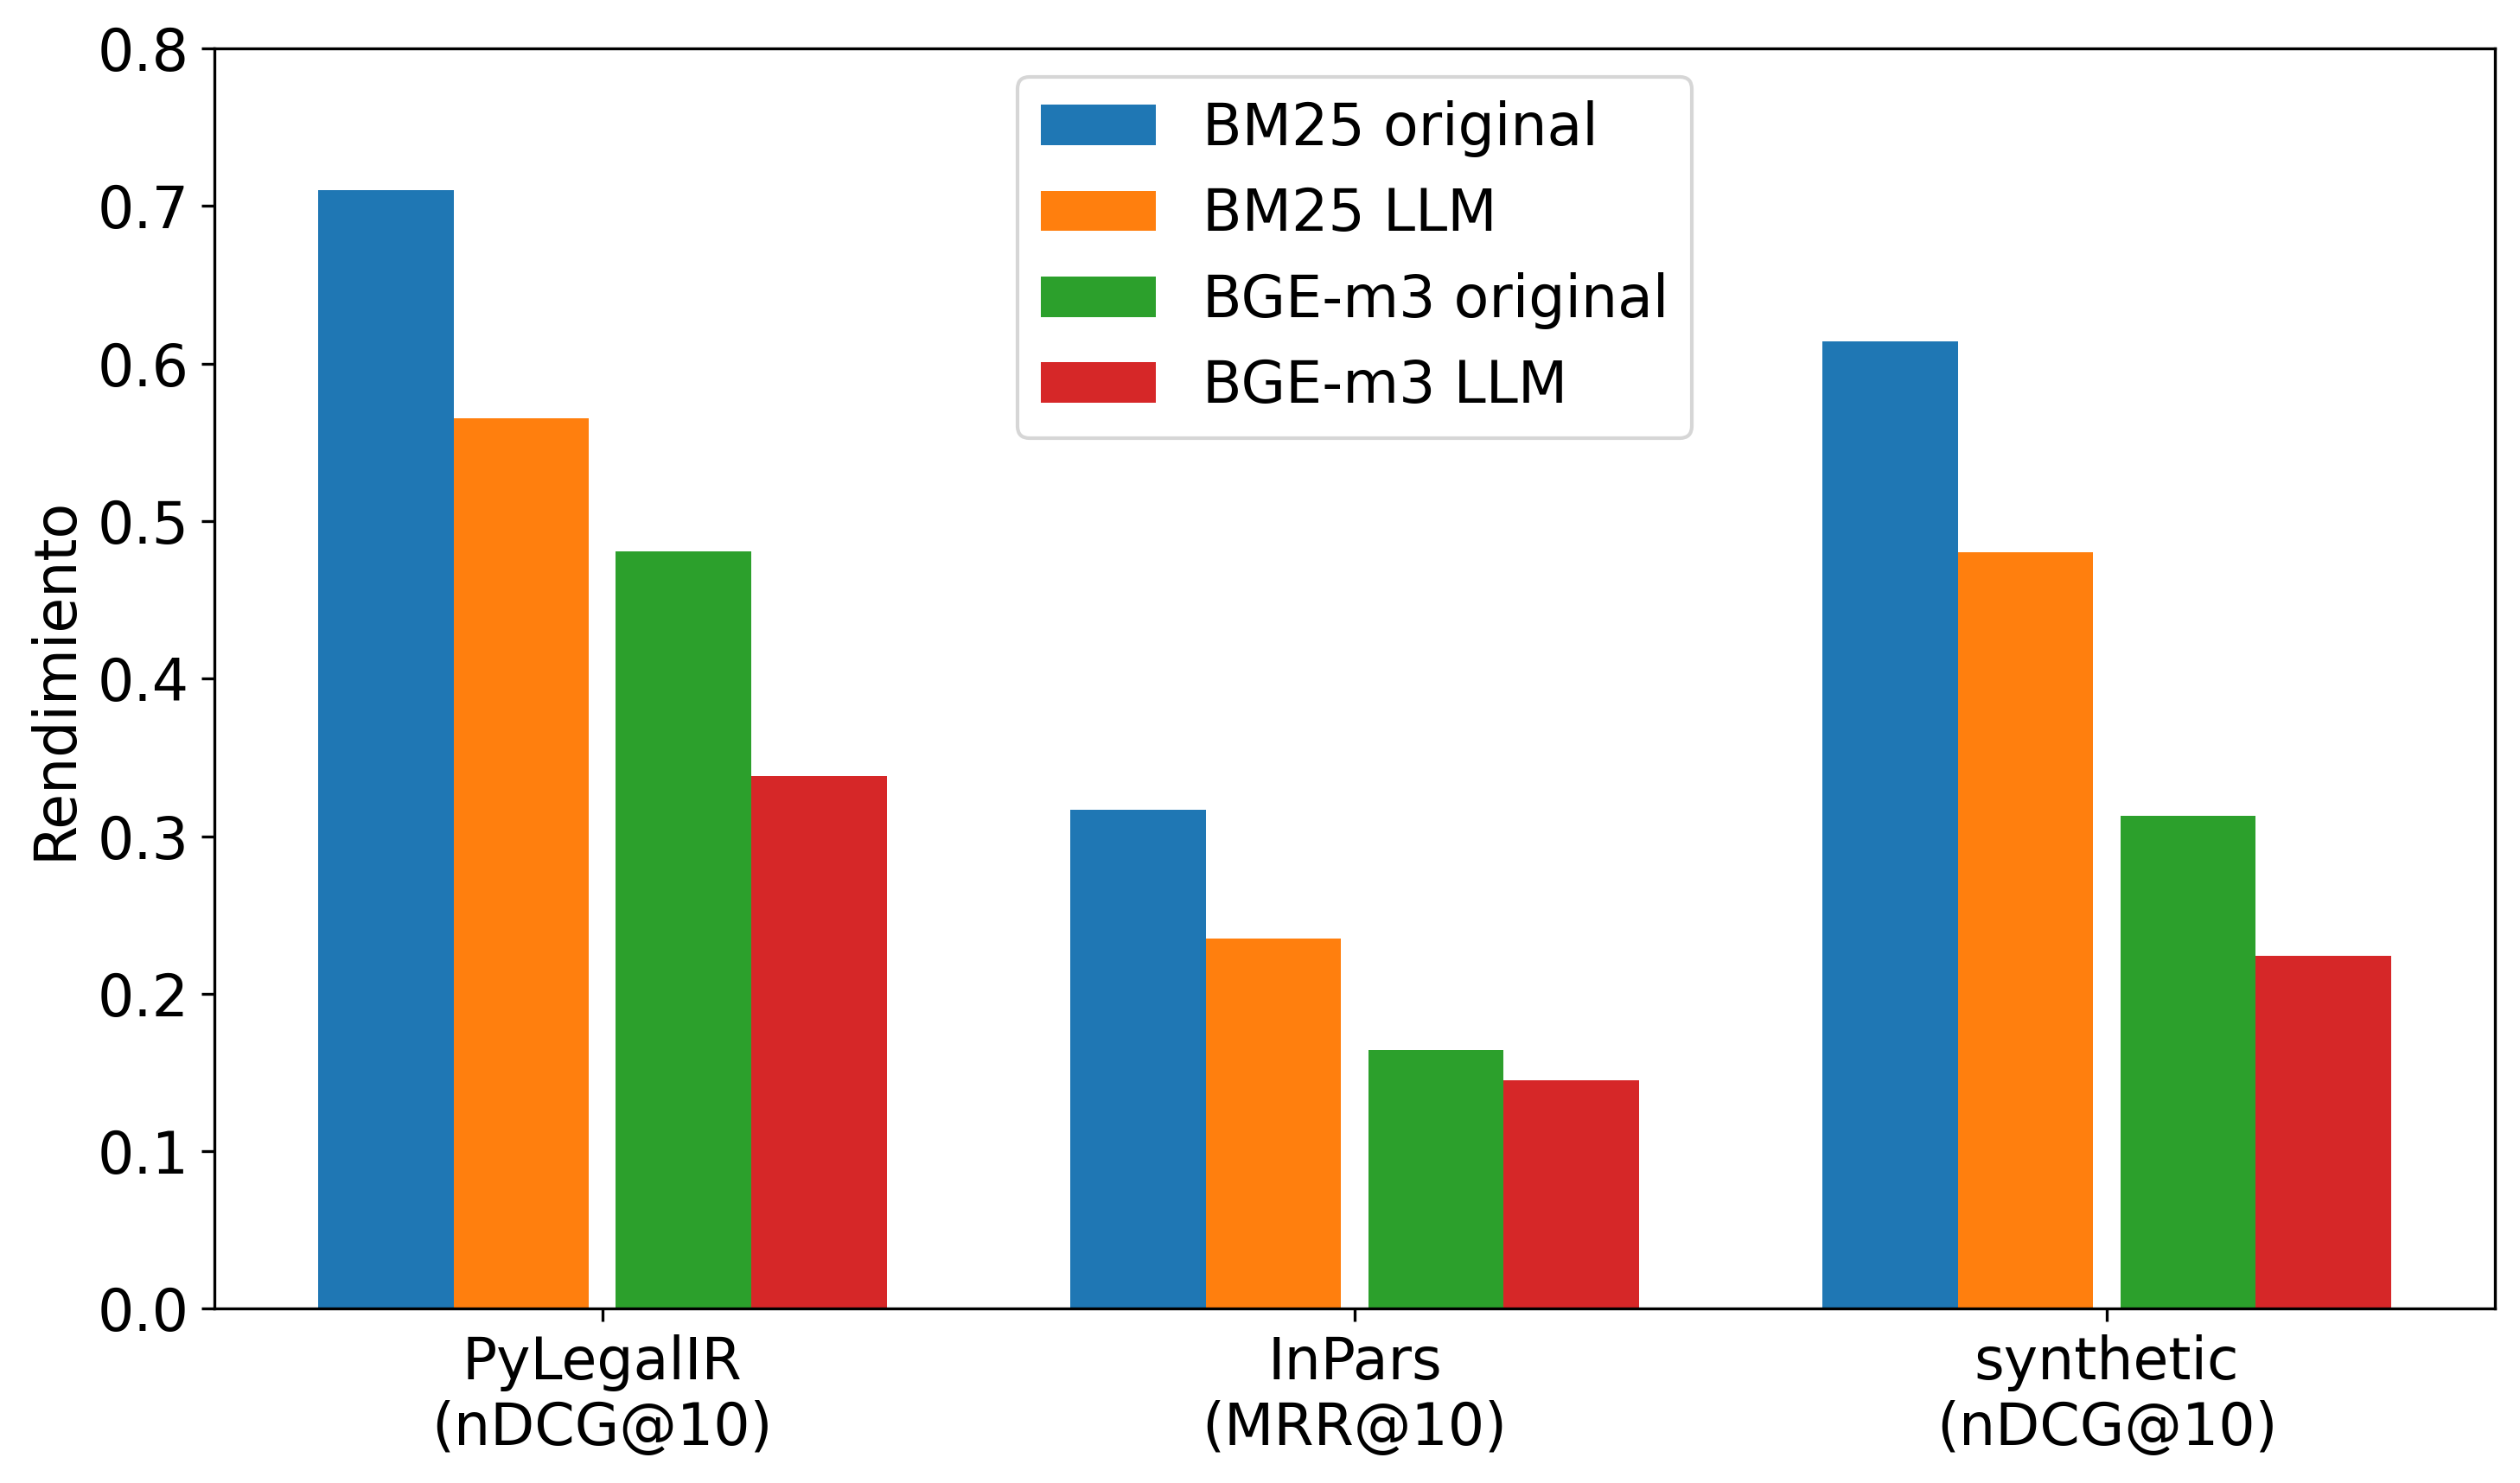

In [20]:
"""
Grouped-bar plot comparing Tesseract vs. Google OCR on three retrieval
benchmarks for two retrieval models (BM25 and BGE-m3).

The script shows the figure interactively and also saves it as
`ocr_comparison.png` in the working directory.
"""

from __future__ import annotations

import pathlib
from typing import Final

import matplotlib.pyplot as plt
import numpy as np


def plot_ocr_comparison() -> plt.Figure:
    """
    Create and return the OCR-comparison bar chart.

    Returns
    -------
    matplotlib.figure.Figure
        Handle to the generated figure.
    """
    # -----------------------------------------------------------------
    #  Data
    # -----------------------------------------------------------------
    datasets: Final[list[str]] = [
        "PyLegalIR\n(nDCG@10)",
        "InPars\n(MRR@10)",
        "synthetic\n(nDCG@10)",
    ]

    bm25_auto = np.array([0.71, 0.317, 0.614])
    bm25_gpt = np.array([0.565, 0.235, 0.48])

    bge_auto = np.array([0.481, 0.164, 0.313])
    bge_gpt = np.array([0.338, 0.145, 0.224])

    # -----------------------------------------------------------------
    #  Plot
    # -----------------------------------------------------------------
    x = np.arange(len(datasets))        # [0, 1, 2]
    bar_w = 0.18                        # width of each individual bar

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)  # one single plot (no sub-plots)

    # BM25 bars
    ax.bar(x - 1.6 * bar_w, bm25_auto, bar_w, label="BM25 original")
    ax.bar(x - 0.6 * bar_w, bm25_gpt, bar_w, label="BM25 LLM")

    # BGE-m3 bars
    ax.bar(x + 0.6 * bar_w, bge_auto, bar_w, label="BGE-m3 original")
    ax.bar(x + 1.6 * bar_w, bge_gpt, bar_w, label="BGE-m3 LLM")

    # Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Rendimiento")
    # ax.set_title("Impact of OCR engine on retrieval performance")
    ax.set_ylim(0.0, 0.8)
    ax.legend()
    fig.tight_layout()

    return fig


def main() -> None:
    """
    Create the plot, display it, and write it to disk.
    """
    fig = plot_ocr_comparison()
    plt.show()


if __name__ == "__main__":
    main()


Chunking + Párrafo nDCG+MRR

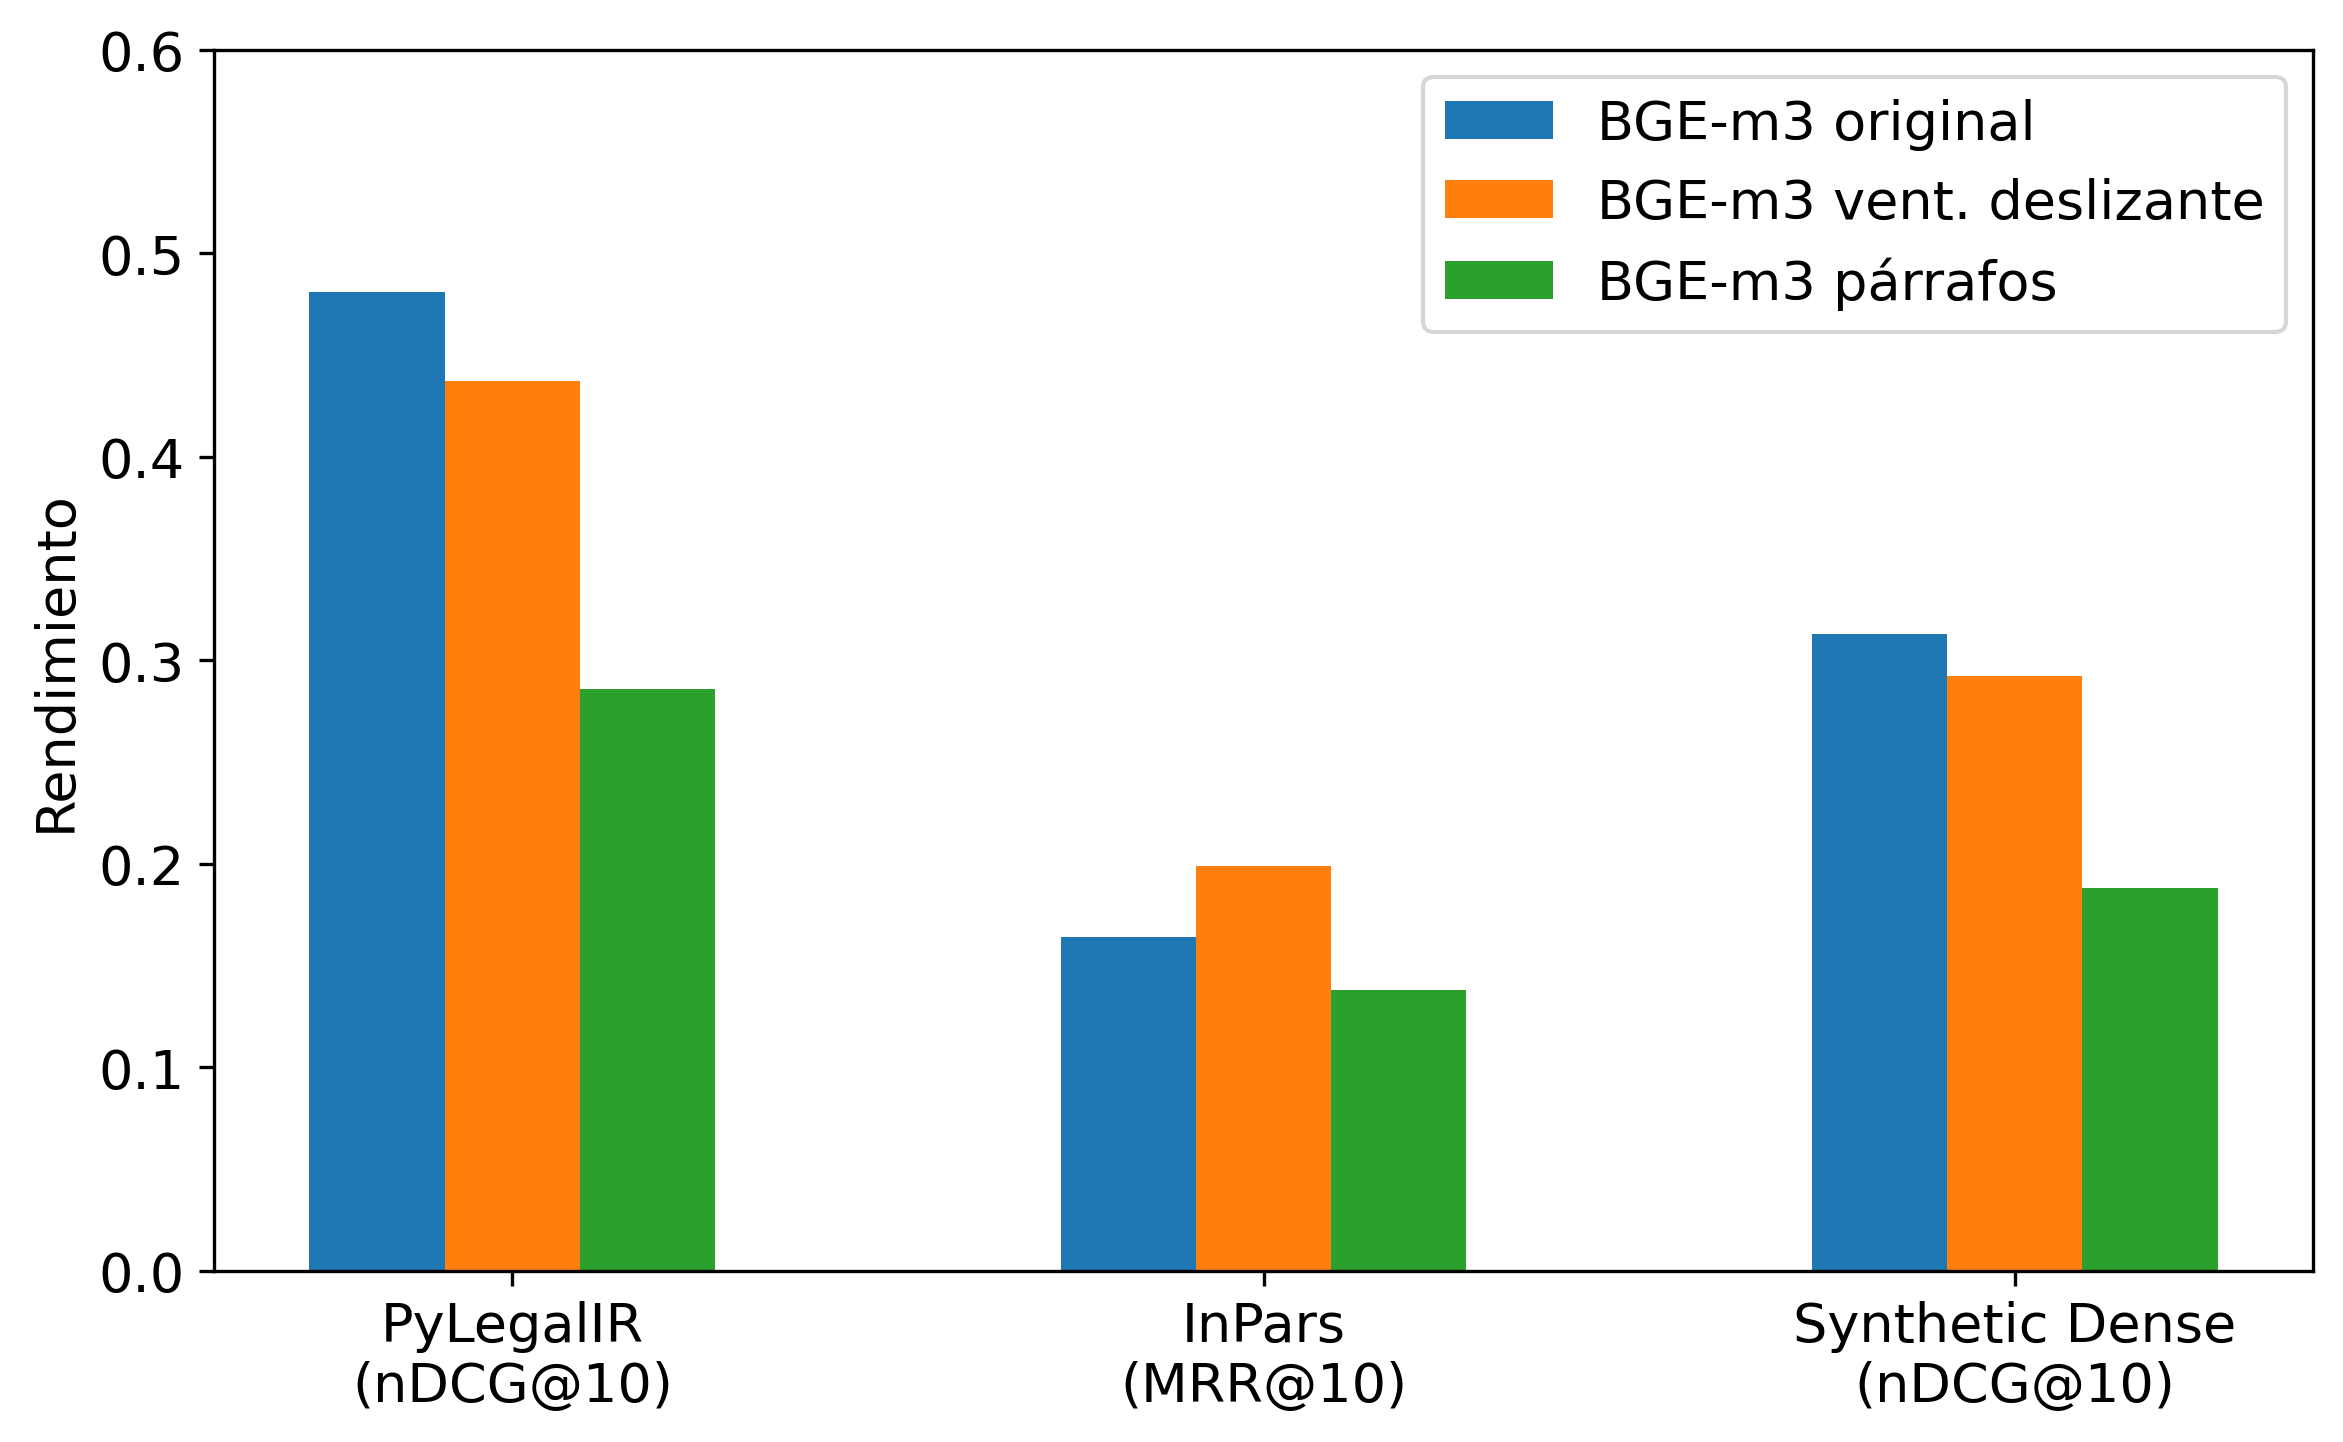

In [15]:
"""
Grouped-bar plot comparing Tesseract vs. Google OCR on three retrieval
benchmarks for two retrieval models (BM25 and BGE-m3).

The script shows the figure interactively and also saves it as
`ocr_comparison.png` in the working directory.
"""

from __future__ import annotations

import pathlib
from typing import Final

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
import numpy as np


def plot_ocr_comparison() -> plt.Figure:
    """
    Create and return the OCR-comparison bar chart.

    Returns
    -------
    matplotlib.figure.Figure
        Handle to the generated figure.
    """
    # -----------------------------------------------------------------
    #  Data
    # -----------------------------------------------------------------
    datasets: Final[list[str]] = [
        "PyLegalIR\n(nDCG@10)",
        "InPars\n(MRR@10)",
        "Synthetic Dense\n(nDCG@10)",
    ]

    bge_full = np.array([0.481, 0.164, 0.313])
    bge_chunking = np.array([0.437, 0.199, 0.292])
    bge_paragraph = np.array([0.286, 0.138, 0.188])

    # -----------------------------------------------------------------
    #  Plot
    # -----------------------------------------------------------------
    x = np.arange(len(datasets))        # [0, 1, 2]
    bar_w = 0.18                        # width of each individual bar

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)  # one single plot (no sub-plots)

    # BM25 bars
    ax.bar(x - 1 * bar_w, bge_full, bar_w, label="BGE-m3 original")
    ax.bar(x - 0 * bar_w, bge_chunking, bar_w, label="BGE-m3 vent. deslizante")
    ax.bar(x + 1 * bar_w, bge_paragraph, bar_w, label="BGE-m3 párrafos")

    # Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Rendimiento")
    # ax.set_title("Impact of OCR engine on retrieval performance")
    ax.set_ylim(0.0, 0.6)
    ax.legend()
    fig.tight_layout()

    return fig


def main() -> None:
    """
    Create the plot, display it, and write it to disk.
    """
    fig = plot_ocr_comparison()
    plt.show()


if __name__ == "__main__":
    main()


Chunking + Parrafo (Recall@100)

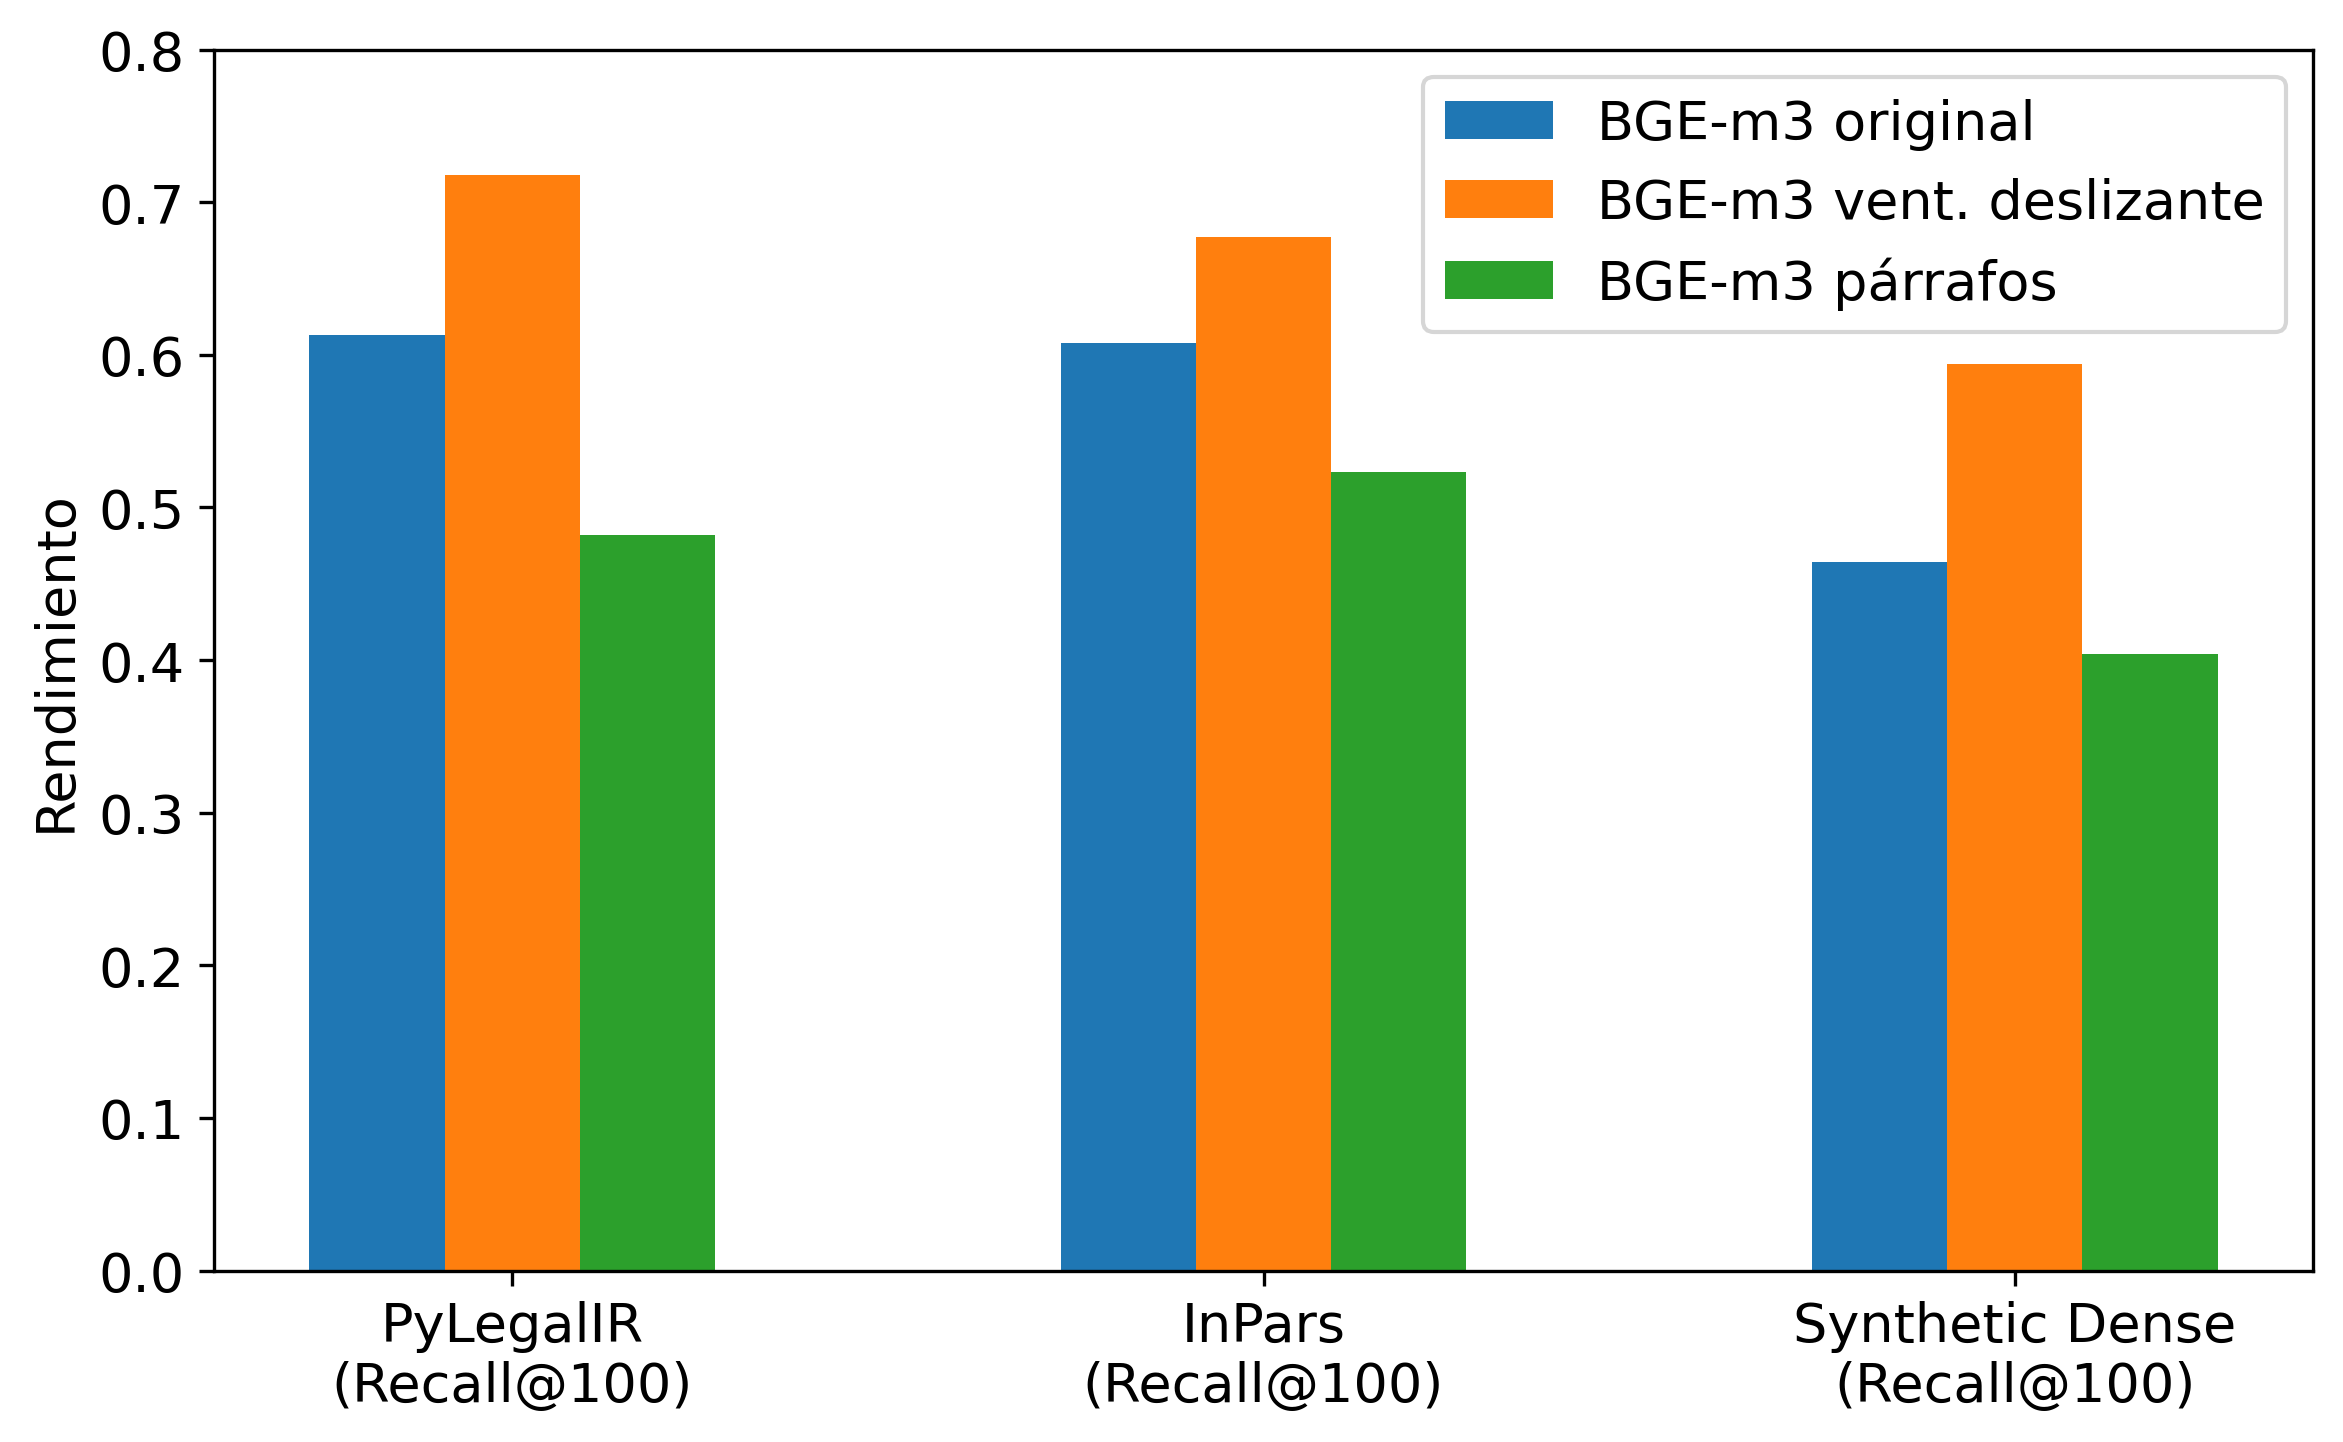

In [13]:
"""
Grouped-bar plot comparing Tesseract vs. Google OCR on three retrieval
benchmarks for two retrieval models (BM25 and BGE-m3).

The script shows the figure interactively and also saves it as
`ocr_comparison.png` in the working directory.
"""

from __future__ import annotations

import pathlib
from typing import Final

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import numpy as np


def plot_ocr_comparison() -> plt.Figure:
    """
    Create and return the OCR-comparison bar chart.

    Returns
    -------
    matplotlib.figure.Figure
        Handle to the generated figure.
    """
    # -----------------------------------------------------------------
    #  Data
    # -----------------------------------------------------------------
    datasets: Final[list[str]] = [
        "PyLegalIR\n(Recall@100)",
        "InPars\n(Recall@100)",
        "Synthetic Dense\n(Recall@100)",
    ]

    bge_full = np.array([0.613, 0.608, 0.464])
    bge_chunking = np.array([0.718, 0.677, 0.594])
    bge_paragraph = np.array([0.482, 0.523, 0.404])

    # -----------------------------------------------------------------
    #  Plot
    # -----------------------------------------------------------------
    x = np.arange(len(datasets))        # [0, 1, 2]
    bar_w = 0.18                        # width of each individual bar

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)  # one single plot (no sub-plots)

    # BM25 bars
    ax.bar(x - 1 * bar_w, bge_full, bar_w, label="BGE-m3 original")
    ax.bar(x - 0 * bar_w, bge_chunking, bar_w, label="BGE-m3 vent. deslizante")
    ax.bar(x + 1 * bar_w, bge_paragraph, bar_w, label="BGE-m3 párrafos")

    # Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.set_ylabel("Rendimiento")
    # ax.set_title("Impact of OCR engine on retrieval performance")
    ax.set_ylim(0.0, 0.8)
    ax.legend()
    fig.tight_layout()

    return fig


def main() -> None:
    """
    Create the plot, display it, and write it to disk.
    """
    fig = plot_ocr_comparison()
    plt.show()


if __name__ == "__main__":
    main()
